# Predicting Daimler AG Stock Price with Machine Learning 

---

## Background:
Simulating prices of stocks and predicting how they will behave in future is considered as one of the toughest, yet often tackled problems in the FinTech industry. For a very long time, data scientists, financial analysts and quant traders have been trying to capture various factors that drive the price of a stock in to some sort of a mathematical/statistical model so that they can perform accurate price predictions towards the future. But due to the multidimensional nature of this problem and not being able to capture the numerous physical, physiological, and irrational factors causing the high volatility of stock prices in a single model, it has made this a challenge yet to be fully solved regardless of all advancements that’ve taken place in research and scientific domains.

In this project, I plan to work on historical stock price data of [Daimler group](https://www.daimler.com/en/) at the [Frankfurt Stock Exchange](http://www.frankfurtstockexchange.de/) and implement different machine learning algorithms to predict future prices of this stock. Ideally, this project would allow me to understand the best candidate ML modelling techniques and approaches which can be used to tackle time-series forecasting problems.

**Data source**: [quandl.com | Daimler (DAI_X)](https://www.quandl.com/data/FSE/DAI_X-Daimler-DAI_X)
 
___


## 1. ENVIRONMENT SETUP <a id='env_1_0'></a>

First let's import all python packages/modules, helper functions and raw data used in this project.

#### 1.1 Required packages <a id='env_1_1'></a>

In [1]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pf
from tqdm import tqdm as tqdm

import warnings
warnings.filterwarnings("ignore")

with warnings.catch_warnings():    
    import xgboost as XGB
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import eli5
    from eli5.sklearn import PermutationImportance
    from bayes_opt import BayesianOptimization
    from statsmodels.tsa.stattools import grangercausalitytests
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.api import VAR
    from statsmodels.tools.eval_measures import rmse, aic
    
sns.set_style('whitegrid')
%matplotlib inline

#### 1.2 Import data from [quandl.com](https://www.quandl.com/data/FSE/DAI_X-Daimler-DAI_X) <a id='env_1_2'></a>

 Daily stock price information of **Daimler group** from [Frankfurt Stock Exchange](http://www.frankfurtstockexchange.de/) is extracted through an API from [quandl.com](https://www.quandl.com/data/FSE/DAI_X-Daimler-DAI_X)

In [2]:
daimler_raw = quandl.get("FSE/DAI_X", authtoken="femDZHxVwhTk8dgXDHmG",  start_date="2000-01-01", end_date="2019-07-31")

In [3]:
daimler_raw.head()

,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
Date,,,,,,,,,,
2000-01-20,NaN,NaN,NaN,71.00,NaN,0.0,NaN,None,None,0.0
2000-01-21,NaN,NaN,NaN,71.09,NaN,0.0,NaN,None,None,0.0
2000-01-24,NaN,NaN,NaN,69.90,NaN,0.0,NaN,None,None,0.0
2000-01-25,NaN,NaN,NaN,67.50,NaN,0.0,NaN,None,None,0.0
2000-01-26,NaN,NaN,NaN,67.10,NaN,0.0,NaN,None,None,0.0


---
## 2. EDA & DATA PREPROCESSING <a id='eda_2_0'></a>

This section includes the **exploratory data analysis** and **data preprocessing** steps which are performed on the on the extracted stock price data.

### 2.1 EDA <a id='eda_2_1'></a>

This section will primarily focus on trying to get a better understanding/sense about the raw stock price data that was extracted through the API.

As the [quantdl documentation](https://www.quandl.com/data/FSE-Frankfurt-Stock-Exchange/documentation) explains, all *(time-series)* datasets from [Frankfurt Stock Exchange](http://www.frankfurtstockexchange.de/) contain information under **11 variables**. They are:
* Date
* Open
* High
* Low
* Close
* Change
* Traded Volume
* Turnover
* Last Price of the Day
* Daily Traded Units
* Daily Turnover

Prior moving to analysis phase, it's best to generate a summary-overview across all these variables so that it provides a 'feel' about the data at hand.

In [44]:
pf.ProfileReport(daimler_raw)

Number of variables,11
Number of observations,5031
Total Missing (%),38.0%
Total size in memory,432.5 KiB
Average record size in memory,88.0 B
Numeric,4
Categorical,0
Boolean,1
Date,1
Text (Unique),0
Rejected,5


###### What does the summary say...

* About `Date`:
    * The extracted time series data ranges from **2000-01-20** till **2019-07-31** 
    

* About `Open`, `High`, `Low`, `Close`:
    * As names suggests, these 4 variables provide information about the;
        * <u>opening</u> stock price for a specific day,
        * <u>highest recorded</u> stock price for a specific day,
        * <u>lowest recorded</u> stock price for a specific day,
        * <u>closing</u> stock price of a specific day, respectively and the main aim of this project would be to successfully predict values of these variables for a future date.
    *  Considering the nature of stock prices, it's obvious that the available **4 price measurements data will be highly correlated with each other** since all 4 price points will vary in a tight range, close to each other on a daily basis *(i.e., if one measure increase/decrease, the remaining 3 will behave simlarly)*
    * This is also confirmed through the initial analysis and it's seen that these 4 variables are having extremely high correlation coefficients *(~.99)*
    * Due to this matter, for the **price prediction task**, it's meaningful to **only consider 1 of these measurements** and ignore the remaining 3.
    * Even though the above report suggests to consider `Open` price and drop the remaining 3, from a parctical point of view, it makes sense to consider **`Close` price** for the analysis and prediction stages since it allows <u>an inverstor to get a sense of whether the price will **rise or fall** at the end of a specific day compared with previous day's closing stock price</u>.
    * Furthermore, we can see that there exists a considerable amount of **missing** values for `Open` variable, thus we can expect to observe similar behavior on `Close` as well. Ideally, it would be required to drop observations which does not include **closing** stock price information prior doing any analysis.
    * `Open` price data seems to follow an approximately normal distribution, which might come handy at later stages.
    
    
* About `Change`:
    * This variable contains **too much missing data *(~99%)*,** thus would be best to **avoid using** for any analysis.
 

* About `Traded Volume`:
    * It can be assumed that, as the name suggests, this variable would contain information about the **amount of stock units traded within a specific day**.
    * Can be idenfied as one of the variables with **least missing values**, thus would be a good feature to include during the analysis/modelling stage.
    * The distribution is highly skewed towards right, thus it's possible to apply **transformations** if needed.
    
    
* About `Turnover`:
    * Similar to `Traded Volume`, have a right-skewed distribution.
    * Contains a **considerable amount of missing-values**, thus would be **best to avoid using** for analysis/prediction stages.
    
    
* About `Last Price of the Day` and `Daily Traded Units`:
    * Both these variables only contain the **constant value *None*,** therefore won't be suitable for any analysis/prediction tasks.
    
    
* About `Daily Turnover`:
    * Majority of the information is **missing**, best to **not use** during analysis/prediction stages.

### 2.2 Variable selection, analysis and data imputation

As per above observation, it's evident that only the `Date`, `Close` and `Traded Volume` variables can be considered for the analysis and prediction tasks, and it's best to drop the remaining variables from the dataset.

In [4]:
vars_keep = ['Close','Traded Volume']

daimler_df = daimler_raw[vars_keep].copy()
daimler_df.head()

,Close,Traded Volume
Date,,
2000-01-20,71.00,0.0
2000-01-21,71.09,0.0
2000-01-24,69.90,0.0
2000-01-25,67.50,0.0
2000-01-26,67.10,0.0


Now let's further analyze the reduced dataset to come up with a final dataset to work with.

Since it was only the `Open` price values examined during the initial summary analysis, let's analyze `Close` values now...

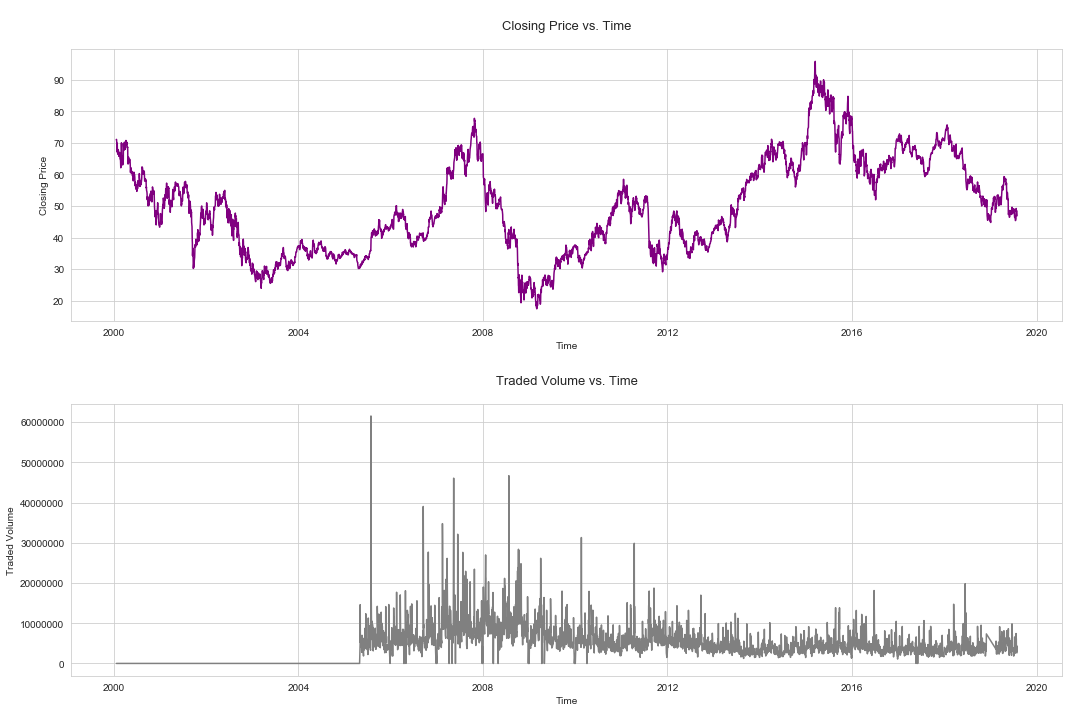

In [5]:
fig, ax = plt.subplots(ncols=1,nrows=2,figsize = (15,10))

sns.lineplot(data=daimler_df['Close'],c='purple',ax=ax[0])
sns.lineplot(data=daimler_df['Traded Volume'],c='grey',ax=ax[1])

ax[0].set_ylabel('Closing Price')
ax[0].set_xlabel('Time')
ax[0].set_title('\nClosing Price vs. Time\n', fontsize=13)

ax[1].set_ylabel('Traded Volume')
ax[1].ticklabel_format(axis='y',style='plain')
ax[1].set_xlabel('Time')
ax[1].set_title('\nTraded Volume vs. Time\n', fontsize=13)

plt.tight_layout()

* As it's seen on the above two *(time-series)* plots, even though the `Close` variable has values since the begining of the year 2000, `Traded Volume` variable has started to populate towards the end of year 2004.4


* Due to this reason, it's best to adjust the considered time frame to make sure for that for every day that's considered during the analysis/predictive modelling phase, there will be values for both `Close` and `Traded Volume` variables.


* Let's see since when the `Traded Volume` variable has started getting populated.

In [6]:
print(f"Begining of 'Traded Volume' data:\n{daimler_df[daimler_df['Traded Volume']>0].head(3)}\n")

print(f"End of 'Traded Volume' data:\n{daimler_df[daimler_df['Traded Volume']>0].tail(3)}")

Begining of 'Traded Volume' data:
            Close  Traded Volume
Date                            
2005-05-02  30.59      3035732.0
2005-05-03  30.56      4840597.0
2005-05-04  31.35     14614664.0

End of 'Traded Volume' data:
             Close  Traded Volume
Date                             
2019-07-29  48.470      3040465.0
2019-07-30  47.240      4337942.0
2019-07-31  46.895      2642977.0


* As seen above, `Traded Volume` varible has values starting from **2005-05-02** till the end of considered time period *(i.e., till **2019-07-31**)*


* Therefore, the dataset is further reduced based on the above time-period by dropping all data from **2000-01-20** to **2005-07-31** and the resultant dataset will be considered for all analysis steps hereon.

In [7]:
daimler_df = daimler_df.loc[pd.to_datetime('2005-05-02'):pd.to_datetime('2019-07-31')]

#### 2.2.1 **Analysing the *time-series* nature of the data**

* Now considering the **time-series nature** of this dataset, I think it's best for us to understand the distribution across weekdays to get a better sense of the data at hand.

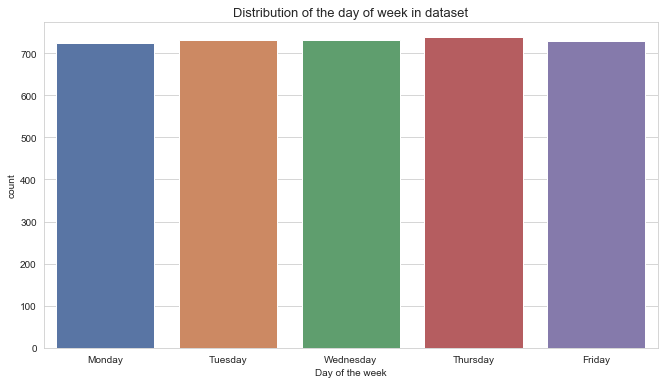

In [10]:
plt.figure(figsize=(11,6))
sns.countplot(daimler_df.index.weekday_name.values,palette='deep')
plt.xlabel('Day of the week')
plt.title('Distribution of the day of week in dataset', fontsize=13)
plt.show()

* As we can observe, we do not have any data during weekends. This can be simply explained because the Frankfurt Stock Exchange does not operate on weekends.

#### 2.2.2 Missing value(s) analysis and Data imputation

* As the second step, let's check if there are any missing values persent in this finalize dataset since having them can cause issue during later stages.

In [49]:
f'There are {daimler_df.isna().sum().max()} rows with missing values' if (daimler_df.isna().sum().max() > 0) else 'No missing values in the dataset'

'There are 46 rows with missing values'

* Prior moving to do any type of an analysis, it would be best to fill these missing values so that they would not cause any trouble during the latter stages.

* In order to see where the missing values lie, let's take a snapshot of the missing data.

In [50]:
daimler_df.loc[daimler_df['Close'].isna() | daimler_df['Traded Volume'].isna() ,:].T

Date,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-17,...,2019-01-31,2019-02-01,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-11,2019-02-12,2019-02-13
Close,51.95,50.45,50.0,46.91,45.47,46.695,47.42,47.54,47.37,47.42,...,51.66,53.03,52.17,52.91,51.95,49.225,48.01,48.16,49.385,50.22
Traded Volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* By observing the above data, it's visible that only the `Traded Volume` variable has missing values.


* Since data for `Close` price is available for the data points where `Traded Volume` is missing, it's possible to **impute data for `Traded Volume`** based on some logical relationship between `Close` prices and `Traded Volume` information.


* Let's first analyse these two variables and see if there seem to exist any such relationship between these two variables. *(e.g., is there any linear relationship between `Close` price vs. `Traded Volume`?)*

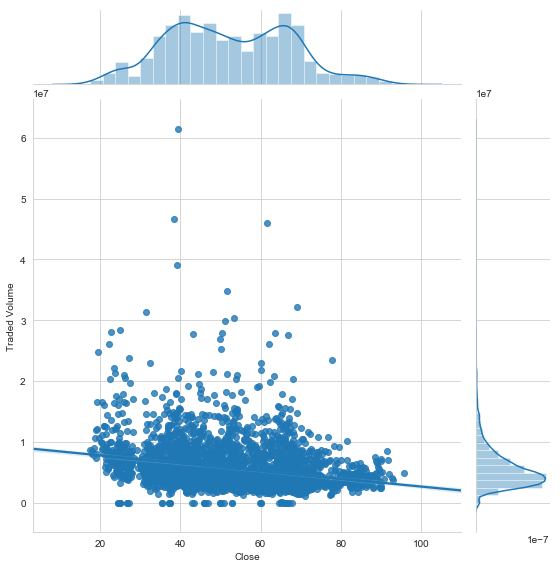

In [11]:
sns.jointplot(x='Close', y='Traded Volume', kind='reg', data=daimler_df,height=8)
plt.show()

By the looks of it, it's observable that **there does not seem to exist any clear relationship** between these two variables.


* Since no direct relationship is visible, here the impuration is carried on based on the following logic:
    * We'll assume that a **similar volumes of stocks are traded on days having similar closing prices**
    * Therefore, for the days where `Traded Volume` is missing, we will consider the `Close` price on the respective days and impute either mean or median of `Traded Volume` values based on available data.
    

* Below section handles the missing value imputation as follows:
    * First we create a new feature by rounding the `Close` values to have **1 decimal point** and convert this to a factor variable so that we can calculate **mean** and **median** of `Traded Volume` values for each `Close` price-point.
    * Afterwards, we create 2 new `Traded Volume` features namely;
        * `traded_vol_mean_imp` : contains `Traded Volume` data with mean imputation
        * `traded_vol_median_imp`: contains `Traded Volume` data with median imputation, and add them to the dataset.

In [12]:
daimler_df['close_rounded'] = np.round(daimler_df['Close'],decimals=1).astype('object')

In [13]:
impute_table = daimler_df.groupby('close_rounded')['Traded Volume'].describe()[['mean','50%']]
impute_table.columns = ['traded_vol_mean_imp','traded_vol_median_imp']

In [14]:
impute_table.head(10)

,traded_vol_mean_imp,traded_vol_median_imp
close_rounded,,
17.4,8592605.0,8592605.0
17.9,8002759.0,8002759.0
18.0,8472457.0,8472457.0
18.2,8034231.0,8034231.0
18.4,7837901.0,7837901.0
18.6,9138644.0,8903929.0
18.9,9646499.0,9646499.0
19.1,12039560.0,12039560.0
19.3,12268610.5,12268610.5


In [15]:
daimler_df['traded_vol_mean_imp'] = daimler_df['Traded Volume']
daimler_df['traded_vol_median_imp'] = daimler_df['Traded Volume']

In [16]:
daimler_df.loc[daimler_df['Traded Volume'].isna() ,'traded_vol_mean_imp'] = daimler_df.loc[daimler_df['Traded Volume'].isna(),'close_rounded'].map(impute_table[['traded_vol_mean_imp']].to_dict()['traded_vol_mean_imp'])
daimler_df.loc[daimler_df['Traded Volume'].isna() ,'traded_vol_median_imp'] = daimler_df.loc[daimler_df['Traded Volume'].isna(),'close_rounded'].map(impute_table[['traded_vol_median_imp']].to_dict()['traded_vol_median_imp'])

* Let's visualize the 2 imputed time-seires for `Traded Volume` and check their behavior

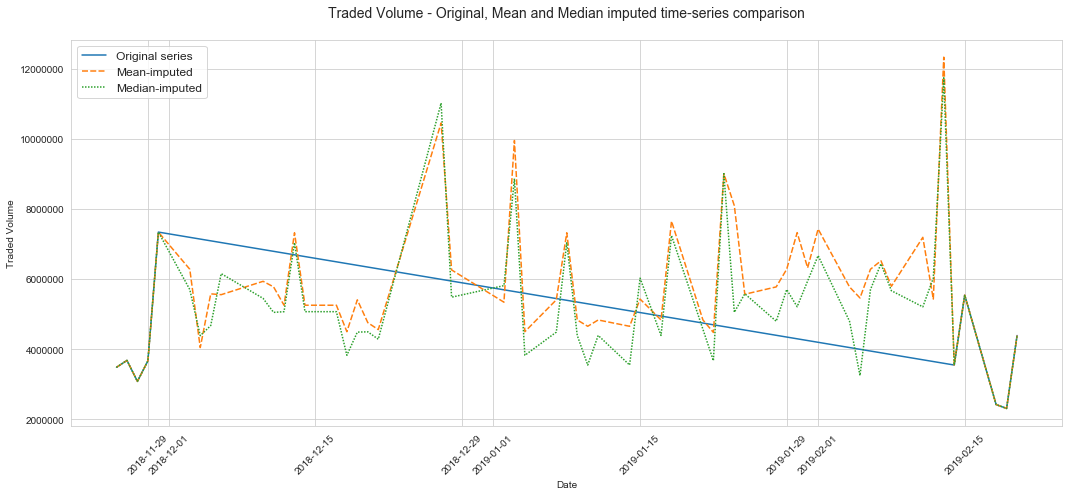

In [17]:
plt.figure(figsize=(15,7))

traded_vol_df = daimler_df.loc[pd.to_datetime('2018-11-25'):pd.to_datetime('2019-02-20'),['Traded Volume','traded_vol_mean_imp','traded_vol_median_imp']]
sns.lineplot(data=traded_vol_df)

plt.xticks(rotation=45)
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Traded Volume')
plt.title('Traded Volume - Original, Mean and Median imputed time-series comparison\n', fontsize=14)
plt.legend(['Original series','Mean-imputed','Median-imputed'],loc=2, fancybox = True, fontsize=12)
plt.tight_layout()


* As it's evident, both **mean** and **median** imputed series seem to behave similarly. Therefore, it's hard to pick one over the other, therefore we will consider both as features during the modelling phase and drop either one of them based on model performance.

#### 2.2.3 Create Train - Test split

* Given that we've properly processed the final dataset, prior moving to the **feature engineering** phrase, we'll create the train and test split.

* When splitting the data into the `train` and `test` sets, here it' **not possible to use the random splitting** since doing so will affect the **time component** in our dataset. Therefore, I will be treating the first **70%** of the dataset as the `train` and keep the remaining as the `test`.

In [18]:
print(f'Dataset has {daimler_df.shape[0]} rows and 70% of it is: {int(np.round(daimler_df.shape[0]*.7,0))} rows\n')

daimler_df.iloc[:2589,:].tail()

Dataset has 3655 rows and 70% of it is: 2558 rows



,Close,Traded Volume,close_rounded,traded_vol_mean_imp,traded_vol_median_imp
Date,,,,,
2015-05-13,84.36,3540117.0,84.4,3540117.0,3540117.0
2015-05-14,86.57,3072945.0,86.6,3072945.0,3072945.0
2015-05-15,85.03,4530216.0,85,4530216.0,4530216.0
2015-05-18,86.47,2999092.0,86.5,2999092.0,2999092.0
2015-05-19,89.37,5798077.0,89.4,5798077.0,5798077.0


* We know that our complete dataset spans from **2005-05-02** till **2019-07-31**. Therefore after considering the above output, we can understand that if we split the full dataset on **2015-05-02** time-point by letting the `training` set have approximately **10 years** of data and keep the remaining **4 years** of data for the `test`, we can achieve an approximate **70-30 split** on the full dataset.

In [19]:
cols_to_extract = ['Close','traded_vol_mean_imp', 'traded_vol_median_imp']

In [20]:
train_set = daimler_df.loc[:pd.to_datetime('2015-05-02'),cols_to_extract]
test_set = daimler_df.loc[pd.to_datetime('2015-05-02'):,cols_to_extract]

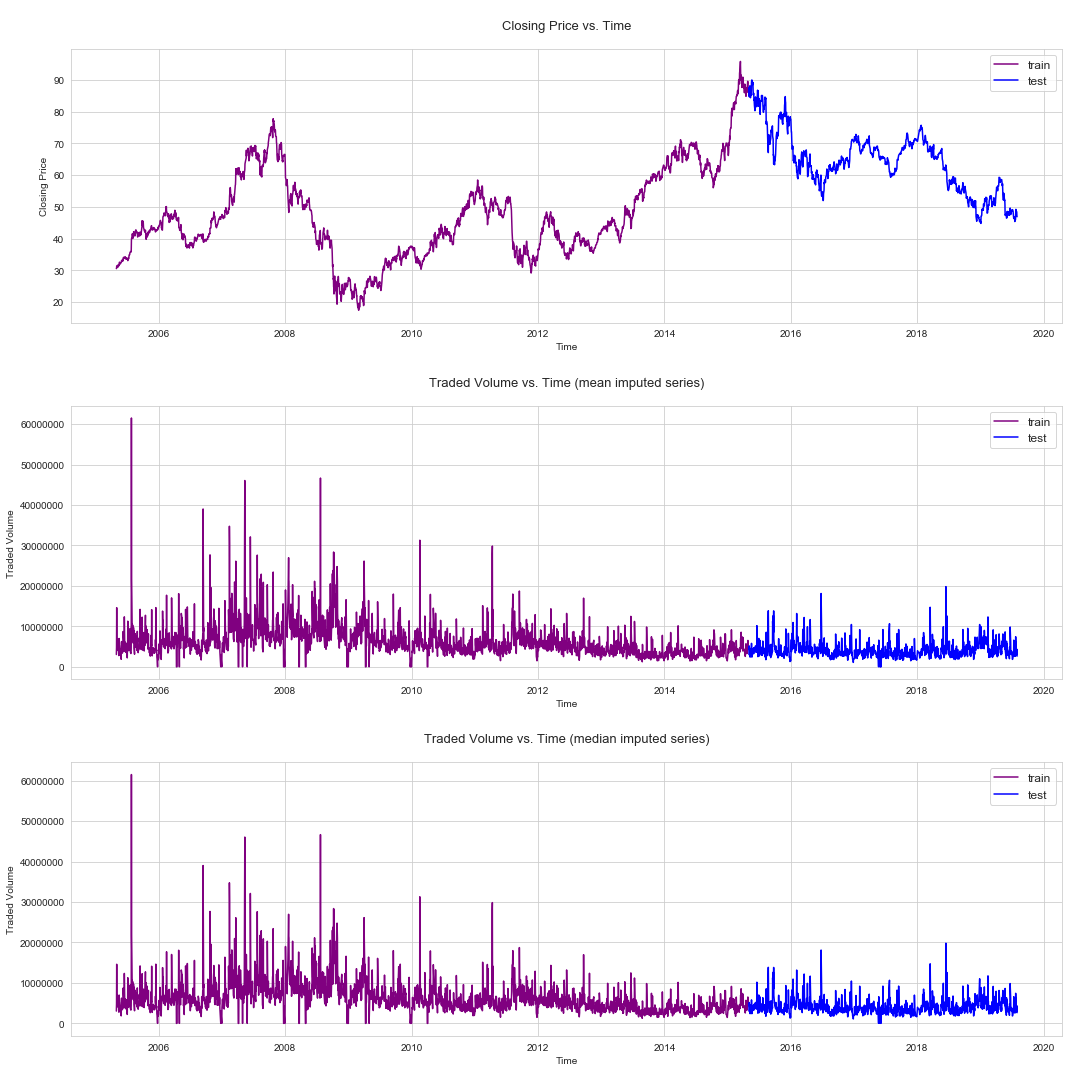

In [21]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize = (15,15))

sns.lineplot(data=train_set['Close'],ax=ax[0],c='purple',label='train')
sns.lineplot(data=test_set['Close'],ax=ax[0],c='blue',label='test')

sns.lineplot(data=train_set['traded_vol_mean_imp'],ax=ax[1],c='purple',label='train')
sns.lineplot(data=test_set['traded_vol_mean_imp'],ax=ax[1],c='blue',label='test')

sns.lineplot(data=train_set['traded_vol_median_imp'],ax=ax[2],c='purple',label='train')
sns.lineplot(data=test_set['traded_vol_median_imp'],ax=ax[2],c='blue',label='test')

ax[0].set_ylabel('Closing Price')
ax[0].set_xlabel('Time')
ax[0].set_title('\nClosing Price vs. Time\n', fontsize=13)
ax[0].legend(fancybox=True,fontsize=12)

ax[1].set_ylabel('Traded Volume')
ax[1].ticklabel_format(axis='y',style='plain')
ax[1].set_xlabel('Time')
ax[1].set_title('\nTraded Volume vs. Time (mean imputed series)\n', fontsize=13)
ax[1].legend(fancybox=True,fontsize=12)

ax[2].set_ylabel('Traded Volume')
ax[2].ticklabel_format(axis='y',style='plain')
ax[2].set_xlabel('Time')
ax[2].set_title('\nTraded Volume vs. Time (median imputed series)\n', fontsize=13)
ax[2].legend(fancybox=True,fontsize=12)

fig.tight_layout()

---
## 3. FEATURE ENGINEERING

* In this section, I will create few additional features using the 2 time-series features which are already contained in the dataset. 

* Aim of creating these new features will be to provide any possible additional information about the behavior of our target variable `Close` price data. These new features would be able improve the forecasting capabilities of any model that we would fit on the dataset


#### The new features I create here will mainly fall under one of the below two categories:

1. **Technical indicators** : Technical indicators are heuristic or mathematical calculations based on the price, volume, or open interest of a stock or contract used by traders who follow technical analysis. *Reference : [Techincal Indicators - Investopedia](https://www.investopedia.com/terms/t/technicalindicator.asp)*

2. **Fourier analysis** : Fourier analysis is a type of mathematical analysis that attempts to identify patterns or cycles in a time series data set which has already been normalized [Fourier Analysis - Investopedia](https://www.investopedia.com/terms/f/fourieranalysis.asp)

3. **Time series features** : Different time related features will be introduced to the feature space hoping that they will allow predictive models to understand any periodic patterns that might exist within the `Close` price distribution


As I've noted above, the idea of creating all these new features would be to include as much as information possible representing different aspects of the data.


### 3.1. Technical indicators

* When working with stock price data, technical indicators are used to get a sense of where the stock price would move next, i.e., would the price move upwards or downwards on the next day.


* There are a lot of such technical indicators available, but for this project I will only consider:
    * **7 and 21 days moving average** : A moving average *(SMA)* is a widely used indicator in technical analysis that helps smooth out price action by filtering out the “noise” from random short-term price fluctuations. It is a trend-following, or lagging, indicator because it is based on past prices. SMA applies an equal weight to all observations in the period. *Reference : [Moving Average - Investopedia](https://www.investopedia.com/terms/m/movingaverage.asp)*
    
    * **Exponential moving average (EMA)** : An exponential moving average *(EMA)* is a type of moving average (MA) that places a greater weight and significance on the most recent data points. An exponentially weighted moving average reacts more significantly to recent price changes. *Reference : [Exponential Moving Average - Investopedia](https://www.investopedia.com/terms/e/ema.asp)*
    
    * **Bollinger bands** : A Bollinger Band® is a technical analysis tool defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the stock price. *Reference : [Bollinger Bands - Investopedia](https://www.investopedia.com/terms/b/bollingerbands.asp)*
    
    * **MACD** :  Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. *Reference : [MACD - Investopedia](https://www.investopedia.com/terms/m/macd.asp)*
    
    
* As we can understand, these technical indicators are highly customarizable.  For this project I am sticking to the **standard/popular settings** for daily price forecasting and will include them as new features to the dataset.
    
    

#### a. SMA:

* This function generates **7-days** and **21-days** SMAs for any given time series. 

In [22]:
def generate_sma(df,var):
    """
    function to generate 7 and 21 days simple moving averages for a specified variable
    """
    sma_7 = str(var)+"_sma_7"
    sma_21 = str(var)+"_sma_21"
    
    df[sma_7] = df[var].rolling(window=7).mean()
    df[sma_21] = df[var].rolling(window=21).mean()

#### b. EMA:

* This function generates **20-days** and **50-days** exponential moving averages for a time series.

In [23]:
def generate_ema(df,var):
    """
    function to generate 20 and 50 days exponential moving averages for a specified variable
    """
    ema_20 = str(var)+"_ema_20"
    ema_50 = str(var)+"_ema_50"
    
    df[ema_20] = df[var].ewm(span=20).mean()
    df[ema_50] = df[var].ewm(span=50).mean()

#### c. Bollinger Bands:

* Here I am using the 21 day SMA as the middle band and calculate upper and lower bands by taking the middle band and adding/substracting twice the daily standard deviation to that amount.

In [24]:
def generate_bollinger_bands(df,var):
    """
    function to generate bollinger bands for 21 days SMA
    """
    sma_21 = str(var)+"_sma_21"
    std_21 = str(var)+"_21_dys_std"
    upr_band = str(var)+"_BB_upper"
    lwr_band = str(var)+"_BB_lower"
    
    df[std_21] = df[var].rolling(window=21).std()
    
    df[upr_band] = df[sma_21] + (df[std_21]*2)
    df[lwr_band] =  df[sma_21] - (df[std_21]*2)
    
    df.drop([std_21], axis=1, inplace=True)

#### d. MACD *(Moving Average Convergence Divergence)*:

* Following the definition, this function generates the MACD for a inputted time series.

In [25]:
def generate_MACD(df,var):
    """
    function to generate MACD
    """
    ema_12 = str(var)+"_ema_12"
    ema_26 = str(var)+"_ema_26"
    MACD = str(var)+"_MACD"
    
    df[ema_12] = df[var].ewm(span=12).mean()
    df[ema_26] = df[var].ewm(span=26).mean()
    
    df[MACD] = df[ema_12] - df[ema_26]

    df.drop([ema_12,ema_26], axis=1, inplace=True)

* Finally, I include all above created functions in a single function so that it's convinient for execution:

In [26]:
def generate_tech_indies(df,var):
    
    df_cpy = df.copy()
    
    generate_sma(df_cpy,var)
    generate_ema(df_cpy,var)
    generate_bollinger_bands(df_cpy,var)
    generate_MACD(df_cpy,var)
    
    return df_cpy

* Now let's generate these techincal indicators for the `Close` price variable and try to visualize the result.

In [27]:
train_w_ind = generate_tech_indies(train_set,'Close')

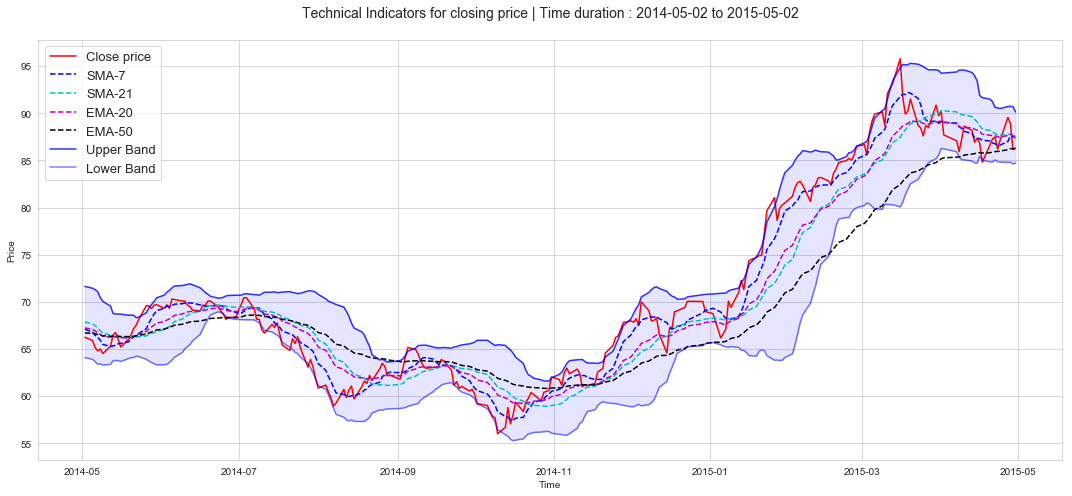

In [28]:
plt.figure(figsize=(15,7))

plt.plot(train_w_ind.loc[pd.to_datetime('2014-05-02'):,'Close'],'r',label = 'Close price')

plt.plot(train_w_ind.loc[pd.to_datetime('2014-05-02'):,'Close_sma_7'],'b--',label = 'SMA-7')
plt.plot(train_w_ind.loc[pd.to_datetime('2014-05-02'):,'Close_sma_21'],'c--',label = 'SMA-21')

plt.plot(train_w_ind.loc[pd.to_datetime('2014-05-02'):,'Close_ema_20'],'m--',label = 'EMA-20')
plt.plot(train_w_ind.loc[pd.to_datetime('2014-05-02'):,'Close_ema_50'],'k--',label = 'EMA-50')

plt.plot(train_w_ind.loc[pd.to_datetime('2014-05-02'):,'Close_BB_upper'], 'b-',alpha=0.8,label = 'Upper Band')
plt.plot(train_w_ind.loc[pd.to_datetime('2014-05-02'):,'Close_BB_lower'], 'b-',alpha=0.5,label = 'Lower Band')

plt.fill_between(x = train_w_ind.loc[pd.to_datetime('2014-05-02'):,['Close_BB_upper','Close_BB_upper']].index,
                 y1 = train_w_ind.loc[pd.to_datetime('2014-05-02'):,['Close_BB_upper']].values.ravel(),
                 y2 = train_w_ind.loc[pd.to_datetime('2014-05-02'):,['Close_BB_lower']].values.ravel(),
                 color='blue',alpha=0.1)

plt.legend(fontsize=13,loc=2,fancybox=True)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Technical Indicators for closing price | Time duration : 2014-05-02 to 2015-05-02\n',fontsize=14)

plt.tight_layout()

* As we can observe through the above plot, the new indicators tend to capture the trend and variance of the `Close` price time series to some extend, thus hopefully will add value and provide more information to any model that we would fit during the modelling phase.

### 3.2. Fourier Analysis / Fourier Transformation features

* The complete Fourier analysis concept, which is called as spectral analysis was originally developed as an engineering tool used to study repetitious activities. 


* The concept of **Fast Fourier Transform ("FFT")** is a calculation that can be computed in a fraction of the time which can be used in during technical analysis to detect cyclical patterns in within time-series data.


* FFTs are developed based on the principal that any finite length time-series can be approximated by decomposing the oroginal series in to a set of sine waves. FFTs take a function and create a series of different sine waves having different amplitudes and frames so that the aggregated waves would approximate the original underlying function.


* Thus FFTs are used for stock price pediction problems due to the ability that they have in extracting the underlying cyclic patterns.


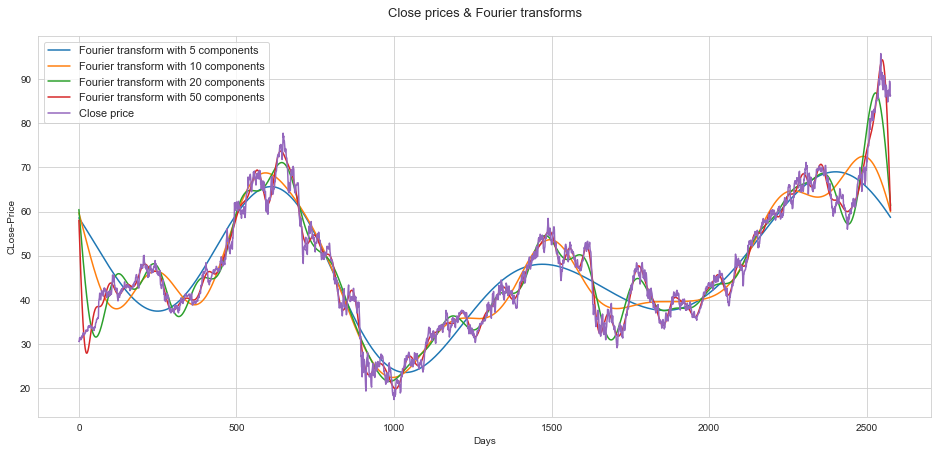

In [29]:
data = train_set.reset_index()[['Date','Close']]
fft_data = np.fft.fft(np.asarray(data['Close'].tolist()))

fft_df = pd.DataFrame({'fft':fft_data})

plt.figure(figsize=(16, 7))

fft_list = np.asarray(fft_df['fft'].tolist())

for comp in [5, 10, 20, 50]:
    fft_list_cpy = np.copy(fft_list)
    fft_list_cpy[comp:-comp]=0
    plt.plot(np.fft.ifft(fft_list_cpy), label=f'Fourier transform with {comp} components')

    
plt.plot(data['Close'],  label='Close price')
plt.xlabel('Days')
plt.ylabel('CLose-Price')
plt.title('Close prices & Fourier transforms\n', fontsize=13)
plt.legend(fontsize=11)
plt.show()

* As we can observe in the above plot, by **including more components** from the Fourier transform we **can derive closer approximations** *(functions)* to the real close price time-series data.

* Since our idea of using fourier transforms here is **to extract long and short term trends in the price data**, we will only use the transforms with **5, 10, and 15 components.** *(observe that 50 component transform tend to overfit the training data)*

In [30]:
def generate_FFT(df,var,components):
    """
    function to generate different Fourier transformations based on number of components for a given time-series
    """
    
    df_cpy = df.copy()
    
    data = df.reset_index()[['Date',var]]
    
    fft_data = np.fft.fft(np.asarray(data[var].tolist()))

    fft_df = pd.DataFrame({'fft':fft_data})
    
    fft_list = np.asarray(fft_df['fft'].tolist())
    
    for comp in components:
    
        fft_name = str(var) + "_FFT_" + str(comp) + "_comp"
    
        fft_list_cpy = np.copy(fft_list)
        fft_list_cpy[comp:-comp]=0
    
        df_cpy[fft_name] = np.abs(np.fft.ifft(fft_list_cpy))
        
    return df_cpy

In [31]:
train_w_FFT = generate_FFT(train_set,'Close',[5,10,20])

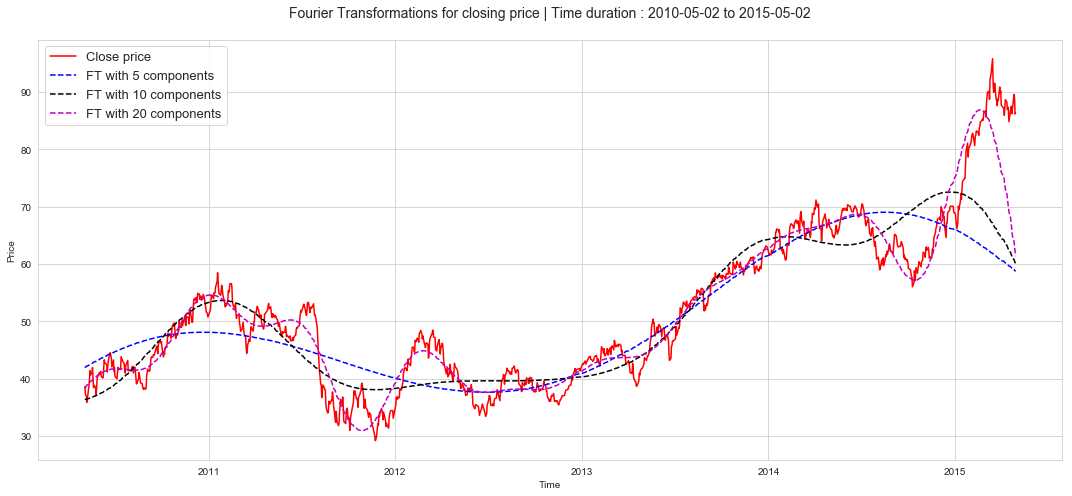

In [32]:
plt.figure(figsize=(15,7))

plt.plot(train_w_FFT.loc[pd.to_datetime('2010-05-02'):,'Close'],'r',label = 'Close price')

plt.plot(train_w_FFT.loc[pd.to_datetime('2010-05-02'):,'Close_FFT_5_comp'],'b--',label = 'FT with 5 components')
plt.plot(train_w_FFT.loc[pd.to_datetime('2010-05-02'):,'Close_FFT_10_comp'],'k--',label = 'FT with 10 components')
plt.plot(train_w_FFT.loc[pd.to_datetime('2010-05-02'):,'Close_FFT_20_comp'],'m--',label = 'FT with 20 components')

plt.legend(fontsize=13,loc=2,fancybox=True)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Fourier Transformations for closing price | Time duration : 2010-05-02 to 2015-05-02\n',fontsize=14)

plt.tight_layout()

### 3.3. Time Series features

* Here, I simply decompose the `Date` variable into different **time-related** features hoping to introduce any trends/periodic patterns related to time aspect.

In [33]:
def generate_time_features(dataset):

    df = dataset.copy()
    
    df['date'] = pd.to_datetime(df.index,format ='%Y%m%D')    
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear    
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.weekofyear
    
    df['timestamp'] = pd.to_datetime(df.index,format ='%Y%m%D').astype(np.int) # convert the `date` to an int so we can feed it to models
    
    df.drop('date',inplace=True,axis=1)
    
    return df

In [34]:
generate_time_features(test_set).head()

,Close,traded_vol_mean_imp,traded_vol_median_imp,dayofweek,dayofmonth,dayofyear,quarter,month,year,weekofyear,timestamp
Date,,,,,,,,,,,
2015-05-04,87.55,3022408.0,3022408.0,0,4,124,2,5,2015,19,1430697600000000000
2015-05-05,85.25,4695912.0,4695912.0,1,5,125,2,5,2015,19,1430784000000000000
2015-05-06,84.67,5161212.0,5161212.0,2,6,126,2,5,2015,19,1430870400000000000
2015-05-07,85.25,4252666.0,4252666.0,3,7,127,2,5,2015,19,1430956800000000000
2015-05-08,88.07,4206482.0,4206482.0,4,8,128,2,5,2015,19,1431043200000000000


### 3.4. Create the final `Train` set with all features

* Here, I include all feature generation functions in a single function since it'll convinient to use for the later stages.

In [35]:
def generate_features(dataset,var,components_for_FFT=[5,10,20]):
    
    df = dataset.copy()
    
    df = generate_time_features(df)
    
    df = generate_FFT(df,var,components_for_FFT)
    
    df = generate_tech_indies(df,var)
        
    return df

In [36]:
train_wt_feat = generate_features(train_set,'Close')

In [37]:
train_wt_feat.head(8).T

Date,2005-05-02,2005-05-03,2005-05-04,2005-05-05,2005-05-06,2005-05-09,2005-05-10,2005-05-11
Close,3.059000e+01,3.056000e+01,3.135000e+01,3.140000e+01,3.150000e+01,3.120000e+01,3.096000e+01,3.108000e+01
traded_vol_mean_imp,3.035732e+06,4.840597e+06,1.461466e+07,5.240720e+06,6.936168e+06,4.437227e+06,4.828932e+06,5.551569e+06
traded_vol_median_imp,3.035732e+06,4.840597e+06,1.461466e+07,5.240720e+06,6.936168e+06,4.437227e+06,4.828932e+06,5.551569e+06
dayofweek,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
dayofmonth,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,9.000000e+00,1.000000e+01,1.100000e+01
dayofyear,1.220000e+02,1.230000e+02,1.240000e+02,1.250000e+02,1.260000e+02,1.290000e+02,1.300000e+02,1.310000e+02
quarter,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
month,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
year,2.005000e+03,2.005000e+03,2.005000e+03,2.005000e+03,2.005000e+03,2.005000e+03,2.005000e+03,2.005000e+03
weekofyear,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.900000e+01,1.900000e+01,1.900000e+01


##### Final `Train` dataset contains:

   * `Close` as the **Target** variable that we are interested to predict.
   * `traded_vol_mean_imp`	and `traded_vol_median_imp` as two predictor variables representing the original `Traded Volume` feature - it would be sufficient to only use one of these two, this I will decide after checking the *feature importance* for predictive purposes.
   * 8 `Date` time related features.
   * 7 technical indicators - again planning to pick the best candidate features after evaluating their importance
   * 3 FFT features - similar to above, will pick the best as needed.
    
As a total, we have **20 features** to predict our target variable.

### 3.5. Calculating **Feature Importance** to pick best predictors:

In order to answer the question,  "*are all these features really necessary?*" for any predictive model, in this section I will be calculating the feature importance of these generated features by following the **[permutation importance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)** approach using the `eli5` library.


* We know there there are many **feature importance** calculation methods avalialble, specially that comes bundled with **boosting and bagging tree** classifier/regressor.

* Many of them calculate the importance of a feature by measuring how effectely a feature reduces the variance when making the predictions. 

* But the feature importance calculated as above is believed to be biased *([Strobl et al, 2007](https://link.springer.com/article/10.1186%2F1471-2105-8-25))* since features with different scales and varying levels tend to influence this importance calculations.

* Therefore, the research community proposes **permutation importance** as a standard to be used in calculating the feature importance which follows the below approach:
    * 1 - Train a model on the data and generate a baseline accuracy.
    * 2 - Shuffle the values of a feature and make predictions using the resulting dataset
    * 3 - Measure the predictive performance reduction against the baseline - this gives the Importance of the feature which we shuffeled values
    * 4 - Repeat above steps for all features
    

Therefore, following the popular recommendation, below I fit a `RandomForestRegressor` and calculate the **permutation importance** in order to select the most influential features for our forecasting problem:

In [38]:
tmp_train = train_wt_feat.iloc[:int(train_wt_feat.shape[0]*0.7),:]
tmp_train.dropna(inplace=True) # drom NaN values of Technical Indicators at the begining of the training dataset

tmp_test = train_wt_feat.iloc[int(train_wt_feat.shape[0]*0.7):,:]

In [39]:
feats = tmp_train.columns.tolist()
feats.remove('Close')

X_train_tmp, Y_train_tmp = tmp_train[feats], tmp_train['Close']
X_test_tmp, Y_test_tmp = tmp_test[feats], tmp_test['Close']

In [40]:
model = RandomForestRegressor(n_estimators=1000).fit(X_train_tmp, Y_train_tmp)

In [41]:
perm_imp = PermutationImportance(model, random_state=1).fit(X_test_tmp, Y_test_tmp )
eli5.show_weights(perm_imp, feature_names = X_test_tmp.columns.tolist())

Weight,Feature
1.4944 ± 0.0751,Close_sma_7
0.0535 ± 0.0015,Close_FFT_20_comp
0.0029 ± 0.0003,Close_MACD
0.0016 ± 0.0001,Close_ema_20
0.0013 ± 0.0001,Close_BB_upper
0.0007 ± 0.0001,Close_FFT_10_comp
0.0004 ± 0.0002,Close_FFT_5_comp
0.0003 ± 0.0000,Close_ema_50
0.0002 ± 0.0002,Close_BB_lower
0.0002 ± 0.0002,Close_sma_21


Above output shows us a measure of importance for each of the features that we used in our training set. 

* Features towards the top of the table have a higher importance whereas features at the bottom has a lower importance.
* First number in each row tells us how much model performance decrease when the random shuffling is performed.
* The number after the '±' sign shows by how much the performance varied for each reshuffled run.
* Features with negative weights gives out the information that, predictions on the shuffled data for the feature appeared to be more accurate than the real data *(meaning, having the feature does not really matter!)*

Based on above results, hereon I will use the first **11** features on the table as inputs to all predictive models which I develop in modelling phase.

In [42]:
feats_to_use = ['Close_sma_7',
                'Close_FFT_20_comp',
                'Close_MACD',
                'Close_BB_upper',
                'Close_ema_20',
                'Close_FFT_10_comp',
                'Close_FFT_5_comp',
                'Close_sma_21',
                'Close_ema_50',
                'traded_vol_mean_imp',
                'Close_BB_lower']

print(f'The list of features to use :\n {", ".join(feats_to_use)}')

The list of features to use :
 Close_sma_7, Close_FFT_20_comp, Close_MACD, Close_BB_upper, Close_ema_20, Close_FFT_10_comp, Close_FFT_5_comp, Close_sma_21, Close_ema_50, traded_vol_mean_imp, Close_BB_lower


### 3.6. Deriving the `X` and `Y` splits to use in models:

* Here I partition the `Train` and `Test` datasets to `X` and `Y` splits so that I can use them during the modelling phase.

In [43]:
X_train, Y_train  = train_set, train_set['Close']

X_test, Y_test  = test_set, test_set['Close']

---
## 4. DATA MODELLING

* Since we've now successfully completed the **feature engineering** task, this section will focus on the predictive modelling and model performance evaluation phases.


* This section will be arrange in the below order:

    1. defining the prediction problem
    1. designing a model evaluation process
    1. fitting a baseline model
    1. fitting different models and evaluation
    


### 4.1. Defining the prediction problem

Given the time-series nature of this stock price prediction problem, I plan to structure the question in hand as below:<br>
    
   1. Candidate models should be able to predict the `Close` price at a future date.<br>
    
        1. Prediction length can be either:
            * single step *(predict one day ahead)* or,
            * multi-step *(predict multiple days ahead)*.
                * **Project-application**: I plan on forecasting the `Close` stock price of **one day ahead**, thus will be an example of a **single-step forecasting problem**<br><br>
        
        1. Training data can have the form of:
            * expanding window *(add test data to the full set of training data as we predict future dates)* or,
            * sliding window *(decide a fixed time-frame to use as training data and adjust it as we predict future dates)*
                * **Project-application**: I plan to **test both cases** and decide the best approach after evaluation.<br><br>
            
        * Fitted models can be evaluated up-on:
            * complete test data *(feed the full test dataset and generate forecast for each time-time step at once)*
            * using a walk-forward method *(forecast for each time step and evaluate the predictive performance)*
                * **Project-application**: I believe the 2nd method is more practical and close to real-world applications, thus will be using a **walk-forward** method for validation.
        
            
   2. Given that there are several engineered features at our disposal, any predictive model we fit should be able to handle  **multiple features**.

Considering all the points mentioned above, I describe the problem in hand as a
   **single-step univariate forecasting problem with a multivariate feature space**

### 4.2. Designing a model evaluation & validation process

#### 4.2.1 Defining a model evaluation metric

* Based on the models' prediction time-length *(1-day in future)*, I plan on **evaluating each forecasted `Close` price value againt the true value** and use it as a metric to measure the predictive power of the respective models.

* This measure would ideally provide us information about how much of an error the model makes when making the forecast.

* At the end of the forecasting period, calling below function will **calculate the `RMSE` *(Root Mean Squared Error)* of the forecasted values at each time step against actuals** and returns the overall RMSE which can be treated as a model evaluation metric.

In [44]:
def evaluate_forecast(actual, predicted):
    
    MSE = mean_squared_error(actual,predicted)
    
    RMSE = np.sqrt(MSE)
    
    return RMSE

#### 4.2.2 Walk-Forward Validation

* Considering the time-oriented nature of our data, I believe the model validation process should also reflect similar charactertistics and be able to evaluate + validate the predictive model(s) while taking such characteristics in to account.


* When **classical cross-validation methods** are applied on the time-series data *(e.g., leave 'p' out cross-validation, 'k' fold cross-validation,etc.)*, **time-ordered nature vanishes due to the randomization.** *(eg., even though we would be interested to use past observations to predict future observations, randomization process of the standard cross-validation algorithms do not support such structure)*


* Therefore, I plan on evaluating the models that I develop using a process called **walk-forward validation** which simply **drops this randomization when setting up the validation set**.


Below implemented Walk-forward validation method requires a predictive model to <u>make a **single-step** forecast and then the actual data for that day would be made available</u>. This **newly available information is then used to calculate the forecast error** and the use as training data when making forecast for the next day.


* I believe this validation approach is more realastic and closely aligns with how we would want to make forecasts in real-world.


* Additionally, this function facilicate both **exapanding-window** and **sliding-window** approaches as I plan on testing out both methodologies prior deciding which to use.

##### 4.2.2.1. Speacial note on training data adjustment

* Having the asssumption that, feature data of the day <i><b>(t)</b></i> should be able to forecast <b>Close</b> price of  day <i><b>(t+1)</b></i>, before feeding the `training` data to a model *(through the walk-forward method)*, I make the following adjustment on the training dataset:
    * a row which contains feature information of day *(t)* will corresponds to predicting the `Close` price value of day *(t+1)* *(e.g., given below)*

|  | Training Data   	|   	|
|:---: |:---:	|:----:	|

| Day | Feature data (X_train)   	|  Target data (Y_train) 	|
|:---: |:---:	|:----:	|
| t-1 | feature data of day (t-1)	| `Close` price of day (t) 	|
| t | feature data of day (t)	| `Close` price of day (t+1) 	|
| t+1 | feature data of day (t+1)	| `Close` price of day (t+2) 	|

   * Above structure supports us when implementing the walk-forward process because the last training sample can be used to predict the `Close` price for the first test data-point and so on.


After incoporating all above information, below function implements the walk-forward validation process and will be used for model fitting purposes.

In [55]:
def walk_forward_validation(model, x_train, x_test, y_train, y_test, feats_to_use,sliding_window_len=None):
    
    temp_x_train = x_train
    temp_x_test = x_test
    
    temp_y_train = y_train
    temp_y_test = y_test
    
    predictions = []
    step_wise_RMSE = []
        
    for obs in tqdm(range(x_test.shape[0])):
                
        # feature-engineer the train
        x_train_ft_engineerd = generate_features(temp_x_train,'Close')[feats_to_use]

        
        ## train data adjustment: apply 1 day off-set for feature-vs-target variable data
        ## here the idea is, feature data from day (t-1) is used to predict the target for day (t)
        
        # adjust the feature-data
        x_train_ft_engineerd_adj = x_train_ft_engineerd.iloc[:-1,:]
        
        # adjust the target variable data
        y_train_adj = temp_y_train[1:]
        
        # if sliding-window defined - adjust the training data length
        if sliding_window_len is not None:
            x_train_ft_engineerd_adj = x_train_ft_engineerd_adj.iloc[-sliding_window_len:,:]
            y_train_adj = y_train_adj[-sliding_window_len:]
            
        
        ## Check if there are training samples with NaN values : can be problamatic for some regressors
        ## Note: several technical indicators results in creating NaN values over the first few samples of the training dataset
        if x_train_ft_engineerd_adj.isna().sum().sum() > 0 :
            
            # merge y_train and x_train data
            merged_training = pd.merge(y_train_adj,x_train_ft_engineerd_adj,left_index=True,right_index=True)
            
            #drop NaN samples
            merged_training.dropna(inplace=True)
            
            # separate-out X_train and Y_train
            y_train_adj =  merged_training['Close']
            x_train_ft_engineerd_adj = merged_training[feats_to_use]

            
        # fit the model
        mod = model.fit(X=x_train_ft_engineerd_adj.values,y=y_train_adj.values)
                               
        # prepare feature data for prediction day: last sample of training data
        x_test_adj = x_train_ft_engineerd.iloc[-1,:]
        
        # predict single step ahead
        one_day_pred = mod.predict(x_test_adj.values.reshape((1,-1)))
        
        # append prediction to list
        predictions.append(one_day_pred) 
        
        # update training feature set by including the last forecasted date's feature data from test set 
        temp_x_train = temp_x_train.append(pd.DataFrame(temp_x_test.iloc[obs]).T)    
        
        # label the x_train index (required for feature-engineering process during next-iteration)
        temp_x_train.index.name = 'Date'

        # extract the last forecasted date's true target value from the test set
        latest_val = pd.DataFrame({'Close': pd.Series(temp_y_test)[obs]}, index = [pd.Series(temp_y_test).index[obs]])
        
        # update the training target set by including the last forecasted date's true target value
        temp_y_train = temp_y_train.append(latest_val['Close']) 

        # label the y_train index (required for feature-engineering process during next-iteration)
        temp_y_train.index.name = 'Date'
        
        # calculate the RMSE for the predictions
        step_wise_RMSE.append(evaluate_forecast(temp_y_test[:obs+1],predictions[:obs+1]))
            
    
    # prepare df of predictions
    predictions = pd.DataFrame(predictions,x_test.index)

    # RMSE for the complete forecast
    RMSE_score = evaluate_forecast(y_test, predictions)

    # generate actual-vs-forecast and error plots
    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
    
    ax[0].plot(y_test,c ='r', alpha = 0.8, label = 'True-value')
    ax[0].plot(predictions,  'b--', alpha = 0.9, label = 'Forecast-value')
    ax[0].legend(fontsize=10)
    ax[0].set_ylabel('Close price')
    ax[0].set_xlabel('Day')
    ax[0].set_title('Forecast vs Actual for Test data\n', fontsize=12)
    
    ax[1].plot(step_wise_RMSE)
    ax[1].set_title(f'Forecast Error',  fontsize=12)
    ax[1].set_xlabel('Test Samples')
    ax[1].set_ylabel('RMSE')
    
    plt.tight_layout()
    plt.show()
    
    print(f'- RMSE for forecast is : {RMSE_score}')
    
    return RMSE_score, predictions, step_wise_RMSE

Below I've implemented a **silent version** of the same walk-forward validation process above *(which does not generate any graphical outputs)* to be used for different experimentation purposes at later stages

In [46]:
def walk_forward_validation_silent(model, x_train, x_test, y_train, y_test, feats_to_use, sliding_window_len=None):
    
    temp_x_train = x_train
    temp_x_test = x_test
    
    temp_y_train = y_train
    temp_y_test = y_test
    
    predictions = []
    step_wise_RMSE = []
        
    for obs in range(x_test.shape[0]):
                
        x_train_ft_engineerd = generate_features(temp_x_train,'Close')[feats_to_use]

        x_train_ft_engineerd_adj = x_train_ft_engineerd.iloc[:-1,:]
        
        y_train_adj = temp_y_train[1:]
        
        if sliding_window_len is not None:
            x_train_ft_engineerd_adj = x_train_ft_engineerd_adj.iloc[-sliding_window_len:,:]
            y_train_adj = y_train_adj[-sliding_window_len:]
            
        if x_train_ft_engineerd_adj.isna().sum().sum() > 0 :
            
            merged_training = pd.merge(y_train_adj,x_train_ft_engineerd_adj,left_index=True,right_index=True)
            
            merged_training.dropna(inplace=True)
            
            y_train_adj =  merged_training['Close']
            x_train_ft_engineerd_adj = merged_training[feats_to_use]

        mod = model.fit(X=x_train_ft_engineerd_adj.values,y=y_train_adj.values)
                               
        x_test_adj = x_train_ft_engineerd.iloc[-1,:]
        
        one_day_pred = mod.predict(x_test_adj.values.reshape((1,-1)))
        
        predictions.append(one_day_pred) 
        
        temp_x_train = temp_x_train.append(pd.DataFrame(temp_x_test.iloc[obs]).T)    
        
        temp_x_train.index.name = 'Date'

        latest_val = pd.DataFrame({'Close': pd.Series(temp_y_test)[obs]}, index = [pd.Series(temp_y_test).index[obs]])
        
        temp_y_train = temp_y_train.append(latest_val['Close']) 

        temp_y_train.index.name = 'Date'            
    
    predictions = pd.DataFrame(predictions,x_test.index)

    RMSE_score = evaluate_forecast(y_test, predictions)
    
    return RMSE_score, predictions

### 4.3 Fitting a baseline model

* Prior moving to fit any sophisticated model(s), I believe **it is crucial to develop a naive forecast model** so that it will provide us an idea about the <u>difficulty of the forecasting problem</u> together with a <u>baseline model performance which can be used to evaluate the predictive capabilities of more sophisticated models</u>.


A naive forecast involves **using the previous observation(s) directly as the forecast** without any change. It is often called the persistence forecast as the prior observations are persisted.

* Below I am implimenting a naive **daily presistence forecast** model, which simply takes the `Close` price of previous day as for forecast of the following day. *(e.g., forecast for Tuesday will be the value of Monday)*

* Ideally, my focus would be to develop more advanced model(s) which would perform better than this naive model.

In [132]:
def daily_persistence(y_train, y_test):
    
    naiv_for_df = y_test.copy()
    naiv_for_df = pd.DataFrame(naiv_for_df)
    naiv_for_df = pd.concat([naiv_for_df,y_test.shift(1)],axis=1)
    naiv_for_df.columns = ['True-Close','1-day-Naive-Forecast']
    
    # since the 1st obs. of the naive-forecast should be the last obs. of Y_train
    y_train_lst_obs = y_train[-1]
    naiv_for_df.fillna(y_train_lst_obs,inplace=True)
    
    MSE = mean_squared_error(naiv_for_df['True-Close'],naiv_for_df['1-day-Naive-Forecast'])
    
    RMSE = np.sqrt(MSE)
    
    plt.figure(figsize=(15,7))
    plt.plot(naiv_for_df['True-Close'],c ='r', alpha = 0.8, label = 'True-value')
    plt.plot(naiv_for_df['1-day-Naive-Forecast'],  'b--', alpha = 0.8, label = '1-day-naive-forecast')
    plt.legend(fontsize=10)
    plt.ylabel('Close price')
    plt.xlabel('Day')
    plt.title('Daily-Presistence Forecast over Test data\n', fontsize=12)
    plt.show()
    
    print(f'- RMSE for daily presistence model is : {RMSE}')
        
    return naiv_for_df, RMSE

### 4.4 Fitting different models and evaluation

Having all the helper functions implemented and ready to be used, in this section I plan on fitting different models and evaluate their performance against the naive model.


* As per the candidate models, I plan on using the below to forecast the future `Close` price value:
    1. Linear Regression
    1. Random Forest Regression
    1. XGBoost Regression
    1. Vector Autoregression (VAR)

    

#### 4.4.1 **Expanding-window** -vs- **sliding-window** : what should we used?


* I believe this is a question that we answer first before we move fitting any model due to the fact that, these two approaches directly affect how we would train the models.

* As we can understand, the **expanding-window** approach would be a **computationally heavy** method since our training sample size would gradually increase as move on to forecast future dates of the test set.


Due to above mentioned reason, I make an initial implementation of **simplistic model** *(linear regression)* to **compare 'expanding-window' vs 'sliding-window' approaches** of model training so that we can decide on which to use when fitting any sophisticated and computationally intensive models.

#### 4.4.2 Forecast using Linear Regression:

Since linear regression model(s) can be considered as one of the most simplistic predictive model(s) in use, I fit this model using the above defined helper functions as below:

* In doing so, I will be using the **deafult hyperparameter values** and test **expanding** vs **sliding** window approaches and compare their results from both **model performance** vs **computational heaviness** aspects.

##### 4.4.2.1 Fitting Linear Regression with default hyperparameters

* *Initialize the model:*

In [133]:
lr_mod = LinearRegression(n_jobs=-1) # with default hyper-parameters

* *apply walk-forward process : expanding-window*

100%|██████████████████████████████████████████████████████████████████████████████| 1078/1078 [00:56<00:00, 19.09it/s]


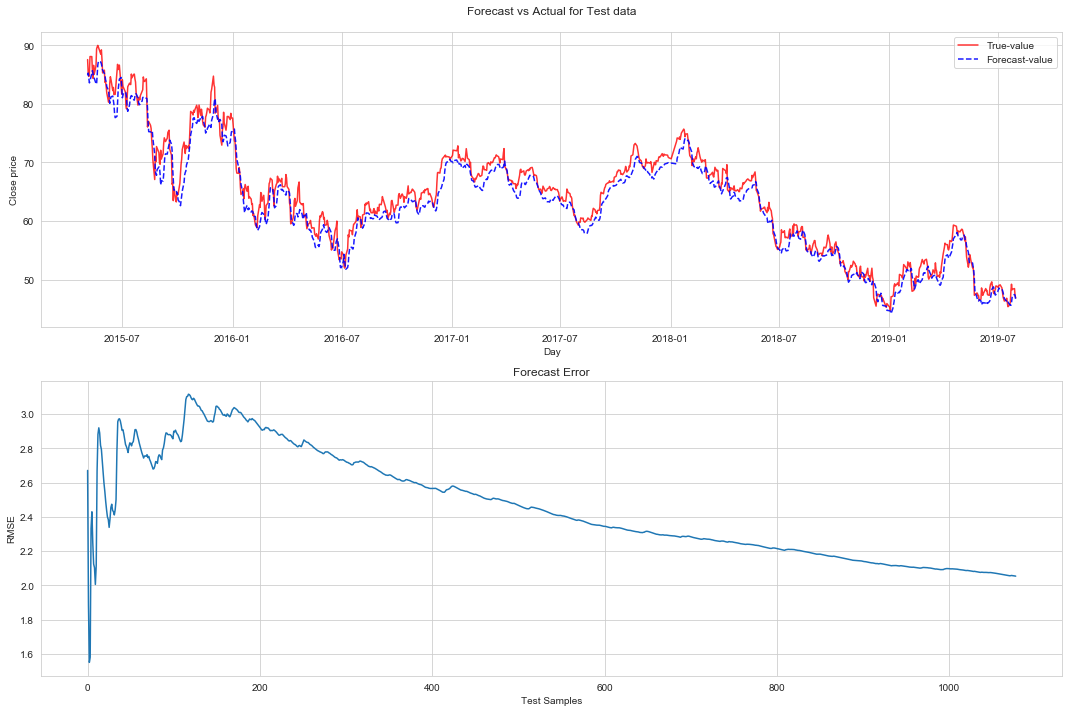

- RMSE for forecast is : 2.0542047982511145


In [134]:
RMSE_sc_lr_ew, pred_lr_ew, step_RMSE_lr_ew = walk_forward_validation(lr_mod, X_train, X_test ,Y_train, Y_test, feats_to_use)

**Observations**:

* By observing the **Actual-vs-Forecast** plot, it's visible that our **prediction is different** from the actual values.
* The overall RMSE of the prediction is ~2.05, which hints us that the linear-regression model might not be the best model to use for this forecasting problem.
* with regards to the timing, the **expanding-window** time approach we employed here has taken roughly about **one minute** to complete the walk-forward process.

**Applying walk-forward process : sliding-window**

* This step I purely employed to compare and understand the **computational ease/efficiency** -vs- any possible **model performance improvements/worsening** that we might observe by using **sliding-window** approach instead of the **expanding-window**
    
* Here, I make an initial assumption that, **1 year worth of histroy**  *(i.e., training data)* would be sufficient for a model to understand the relationship between feature information and target (`Close`) price data to make a **successful 1-day ahead *(single-step)* forecast**.
    
* Therefore, I will define the **sliding-window** to be **260 days** *(~ 5-days x 52 weeks)* when executing the walk-forward process as below.

100%|██████████████████████████████████████████████████████████████████████████████| 1078/1078 [00:53<00:00, 20.09it/s]


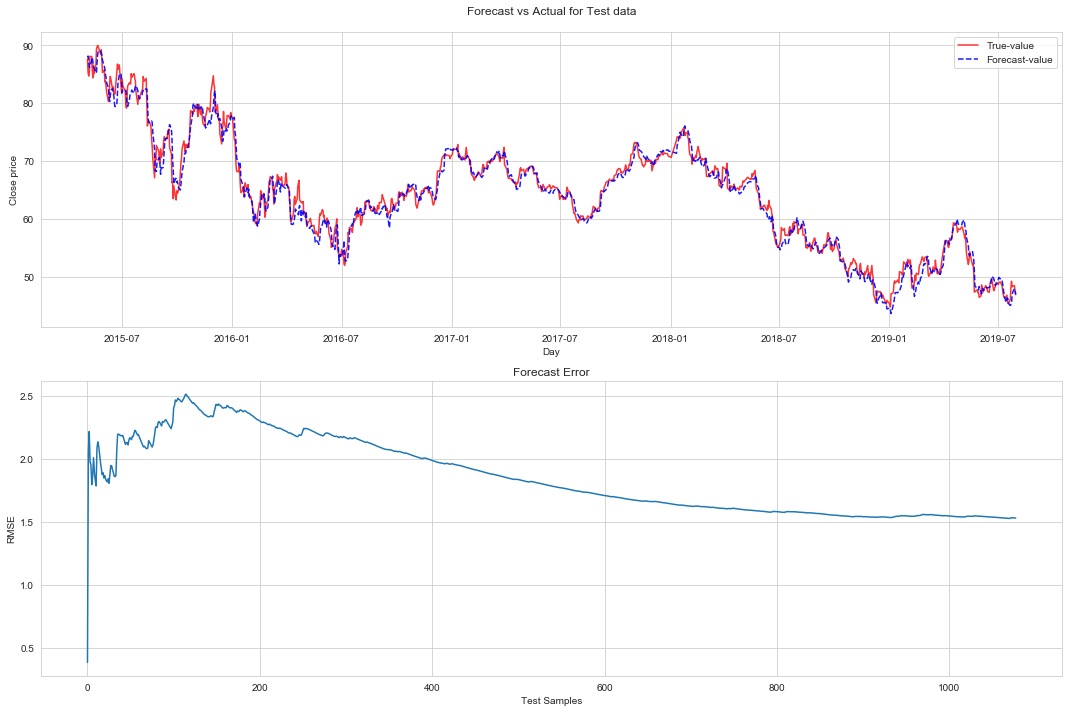

- RMSE for forecast is : 1.532235335685319


In [135]:
RMSE_sc_lr_sw, pred_lr_sw, step_RMSE_lr_sw = walk_forward_validation(lr_mod, 
                                                                     X_train, X_test ,
                                                                     Y_train, Y_test,
                                                                     feats_to_use,
                                                                     sliding_window_len=260)

**Observations**:

* Comparing with the *expanding-window* approach, even though the <u>computational time hasn't dramatically reduced</u> *(only few seconds reduction)*, it's seen that the **RMSE has decreased about 25%** by utilizing the *sliding-window* approach.


* When we examine the **forecast-error** plots, the *sliding-window* approach has resulted with a much more smooth decrease over-time compared with *expanding-window* approach, which showcases a bit more non-smooth error rate as train set grows.

**Why sliding-window approach performce better than expanding-window?**

* I believe we can explain this behavior as the model trained using **<u>expanding-window</u> tends to <u>overfit</u> the training data**, thus might not generalize over the test samples as much as *sliding-window* approach.


* The model trained using **<u>sliding-window</u> would generalize more towards the future dates** because the training set size is kept constant and will always contain latest information.


* Furthermore, employing the **<u>sliding-window</u> approach allows us to put more emphasis on the recent data** during the model fitting, thus results in making better forecasts overall.


* Above helps us to enfore the the assumption that, **future stock prices are more influenced from the recent history/feature information** but not with the extremely old data.

**Conclusions**: 

* Witnessing above results, I believe it's safe for us to pick **<u>sliding-window</u> approach to be used in the walk-forward process** hereon.

* At the same-time, I believe it's worthy to try to pick an **optimal sliding window length**, which would minimize the forecast error for any model that we fit

##### 4.4.2.2 Deciding the 'Optimal Sliding-Window length' for Linear Regression:

* As we noticed on our above experiment, switching to *sliding-window* method resulted in a significant RMSE drop during forecasting phase.


* In other words, it's understandable that by **reducing the training sample size** and **focusing more on the most recent data during model fitting stage** results with an improved forecast accuracy.


* So the obvious question would be, "**what is the best training sample size?**" or in other words, "**what would be the optimal sliding window length?**" to train our models on?


To answer this question, I implement the below function which iterates through **different sliding window lengths**, ranging from **2-days** to **260 days** and fit the same linear regression model we previously initialized and try to identify the **best sliding window length** resulting the **minimum RMSE** value.

In [53]:
 def identify_opt_sliding_window(model, x_train, x_test, y_train, y_test, feats_to_use, min_window_len = 1, max_window_len = 260, step_size = 1):
    
    sliding_window_array = np.arange(min_window_len,max_window_len,step_size)
    
    min_rmse = 1000
    min_rmse_win_len = 0
    rmse_li = []                             
    
    for length in tqdm(sliding_window_array):
                                 
            RMSE_score, _   = walk_forward_validation_silent(model, x_train, x_test , y_train, y_test, feats_to_use, sliding_window_len=length)
        
            rmse_li.append(RMSE_score)

            if RMSE_score <= min_rmse:
                min_rmse = RMSE_score
                min_rmse_win_len = length
    
    rmse_by_window_len_df = pd.DataFrame(rmse_li)
    rmse_by_window_len_df = pd.concat([rmse_by_window_len_df,pd.Series(sliding_window_array)],axis=1)
    rmse_by_window_len_df.columns = ['RMSE','window length']
    rmse_by_window_len_df.set_index('window length', inplace= True)
    
    print(f'- Minimum RMSE of {min_rmse} is resulted at the sliding window length of {min_rmse_win_len} day(s)')
    
    plt.figure(figsize=(14,5))
    plt.plot(rmse_by_window_len_df)
    plt.title(f'Forecast Error',  fontsize=12)
    plt.xlabel('Window length')
    plt.ylabel('RMSE')
    plt.show()
    
    return min_rmse, min_rmse_win_len, rmse_by_window_len_df

Above function fits an input model on a training-set based on range of sliding-window lengths and returns the best RMSE found together with the respective window length and a dataframe containing all sliding window lengths considered and their respective RMSE scores.


* It's obvious that running the above function leads to an extremely heavy computational task, thus for the experimentation purpose, I will be structuring the use of above function on any given model as below:

    * **STEP 1** : **Subset Test-set** - Instead of forecasting over the full-test set for model evaluation, I will use on the the **first 521 test samples**, i.e., up-to two years worth of test-data *(from 2015-05-04 to 2017-05-04)* for the experimentation.

    * **STEP 2** : Run the function with **broad step-sizes**;
        * Here the idea is to get a general sense of how the RMSE behave over the complete sliding-window day range that we are interested in.
    * **STEP 3** : Run the function with **1-day step size**;
        * Once we find a good window length using the above step, then I will run the same function on a narrow sliding window range - but with 1-day step size. This will allow us to check if the non-tested sliding window lengths with step 1 lengths results with an even better RMSE score.

* **Subset the Test-set** : Only consider data from from 2015-05-04 to 2017-05-04 as **test set**

In [48]:
X_test_sub = X_test.iloc[:522,:]
Y_test_sub = Y_test.iloc[:522]

* **STEP 1** : run with 3-day step sizes

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [31:35<00:00, 20.78s/it]


- Minimum RMSE of 1.7591410805188563 is resulted at the sliding window length of 236 day(s)


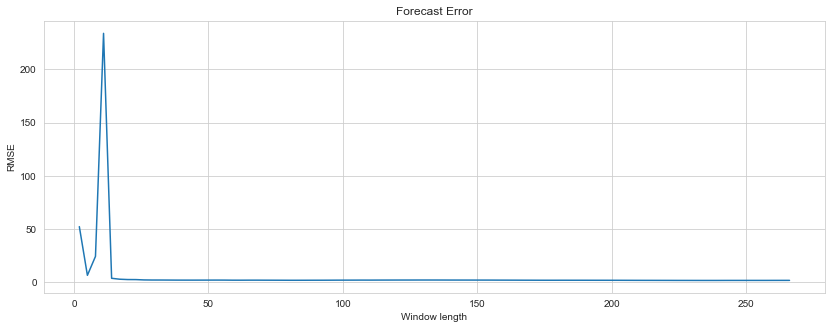

In [138]:
best_rmse_lr1, best_window_len_lr1, rmse_df_lr1 = identify_opt_sliding_window(lr_mod, 
                                                         X_train, X_test_sub,
                                                         Y_train, Y_test_sub,
                                                         feats_to_use,
                                                         min_window_len=2,
                                                         max_window_len=267,
                                                         step_size = 3)

* As we can observe, above results show us that the minimum RMSE score of **1.75914** can be obtained by using the sliding window length of **236-days**.


* And by examining the above generated *RMSE vs Window-length* plot, it seems that after passing the window length of 20 days, RMSE scores tend to vary within a low range.


* Therefore, in oder to check whether there are any other better RMSE scores around the 236-days window length, I run the same process but with a **1-day step-size** over the **236 +/- 20** days length range and check for results.


* **STEP 2** : run with 1 day step size, over the sliding window range from 216 to 256

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [15:56<00:00, 23.76s/it]


- Minimum RMSE of 1.759125710051201 is resulted at the sliding window length of 238 day(s)


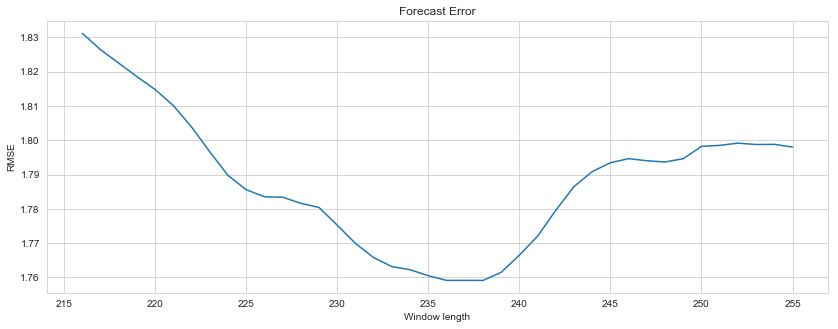

In [139]:
best_rmse_lr2, best_window_len_lr2, rmse_df_lr2 = identify_opt_sliding_window(lr_mod, 
                                                         X_train, X_test_sub,
                                                         Y_train, Y_test_sub,
                                                         feats_to_use,
                                                         min_window_len=216,
                                                         max_window_len=256,
                                                         step_size = 1)

* By observing the above results, we can make the final conclusion that, having a window-length of **238-days** results with the best model with lowest forecast error of **1.75912 RMSE** for **linear regression** over the considered time duration from **2015-05-04 to 2017-05-04**

##### 4.4.2.3 Comparison against Naive Model and deriving conclusion

* With the above results at hand, let's evaluate the forecasting performance of the fitted *linear regression* model against the **daily-presistence** (naive) model which we implemented before.

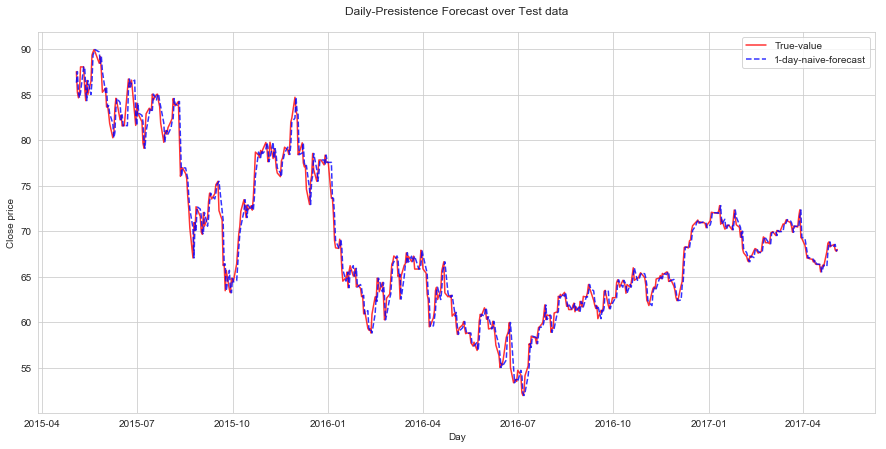

- RMSE for daily presistence model is : 1.2284056576596


In [144]:
naiv_forecast, naiv_rmse = daily_persistence(Y_train,Y_test_sub)

* The daily-presistence model we fit results with a RMSE of **1.2284**, which is **less** the RMSE score for the **linear regression** model we fitted.
<br><br>



**CONCLUSION**

* This provides us enough evidence to understand that, fitting a **linear regression** model **would not** provide us a **better forecast** when compared against naively assuming the forecasted `Close` price would be the same as the day before.

#### 4.4.3 IMPORTANT ADJUSTMENT MADE ON FORECASTING HORIZON *(derive new Test-set)*:

* Even though at first I was planning to use the all samples from **2015-05-04** till **2019-07-30** as the **test-set**, as we have noticed, utilizing this full range for different experimentation stages has turned out to be **highly-time consuming and computationally heavy** due to the implementation of walk-forward validation process.


* Therefore, please note that I will be deviating from the initial plan and only use **2-years worth of test data** ranging from **2015-05-04 to 2017-05-04** for all model evaluation processes.

In [49]:
X_test_reduced = X_test.iloc[:522,:]
Y_test_reduced = Y_test.iloc[:522]

#### 4.4.4 Forecasting using Random Forest

* After witnessing how the **linear regression** model **failed** against the **naive model's** performance, in this section I try to fit a **Random Forest Regressor**, hoping to obtain a better forecasting performance.


* During the initial stages, I will stick to the **default hyperparameter values** and use the default regressor's results to decide whether we should do any further tuning in order to obtain better results.

##### 4.4.4.1 Fitting Random Forest Regressor with default hyperparameters

* Here, I directly execute the `identify_opt_sliding_window()` function hoping to obtain a better idea about which **sliding-window length to use**.


* In doing so, knowing that fitting **random forest regressor would be computationally intensive than fitting the linear regression**, I leverage the findings of our previous attempt *(i.e., fitting the **linear regression** model)* and design the experiment as;
    * First, search on the **2-days to 260-days** window length range with **5-day incremental step-sizes** in order to pick a narrow candidate window length range,
    * Secondly, on the above picked **narrow candidate sliding-window length range**, apply the same function with **1-day step size** to identify the **best sliding-window length** which produces the **minimum rmse**.


* As you can imagine, the above process that I've designed has been based on the same assumption that I made for the linear regression model, which is  **<u>1 year worth of histroy</u> (i.e., training data) would be sufficient for a model to understand the relationship between feature information and target (Close) price data to make a successful 1-day ahead (single-step) forecast**.

In [51]:
rf_mod = RandomForestRegressor(n_jobs=-1)

100%|███████████████████████████████████████████████████████████████████████████████| 52/52 [2:10:03<00:00, 157.27s/it]


- Minimum RMSE of 1.3415396113181421 is resulted at the sliding window length of 2 day(s)


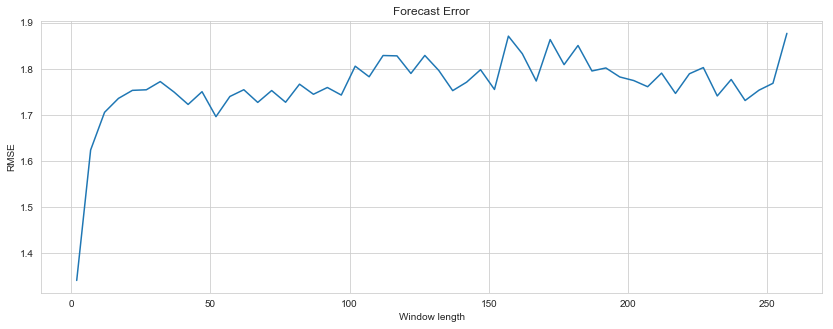

In [143]:
best_rmse_rf_1, best_window_len_rf_1, rmse_df_rf_1 = identify_opt_sliding_window(rf_mod, 
                                                         X_train, X_test_reduced,
                                                         Y_train, Y_test_reduced,
                                                         feats_to_use,
                                                         min_window_len=2,
                                                         max_window_len=260,
                                                         step_size = 5)

* As per the above resulted error plot and the minimum rmse score *(1.3415 RMSE for 2-days window length)*, I consider **2-days to 20-days range** as the candidate window-length and re-run the same process with **1-day** step-size in order to check if it would result with a better outcome.

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [44:28<00:00, 147.23s/it]


- Minimum RMSE of 1.3395260148442225 is resulted at the sliding window length of 2 day(s)


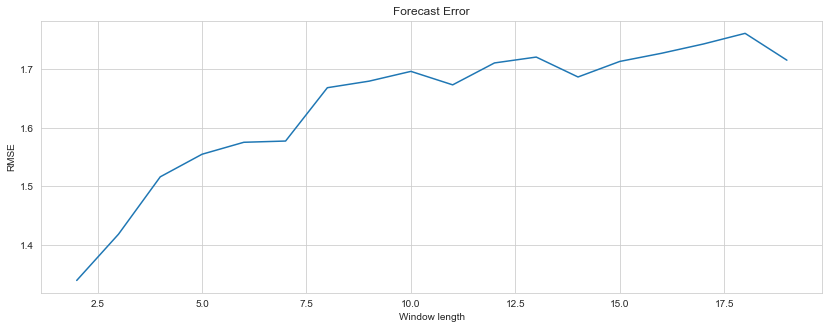

In [54]:
best_rmse_rf_2, best_window_len_rf_2, rmse_df_rf_2 = identify_opt_sliding_window(rf_mod, 
                                                         X_train, X_test_reduced,
                                                         Y_train, Y_test_reduced,
                                                         feats_to_use,
                                                         min_window_len=2,
                                                         max_window_len=20,
                                                         step_size = 1)

**OBSERVATIONS**

* As we can observe from the above result, again the minimum RMSE score is recorded at the sliding window length of **2-days**.


* But as it's seen, the minimum score now *(1.3395)* is **sligtly different** *(lower) than the previously recorded value at the **same window length**.


We can explain this scenario as a result of the **[bootstrap sampling](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) the random forest regressor uses in constructing many different decision trees** *(i.e., Every time we call the regressor, **sub-samples are randomly generated** and thus different results)*. 
* One way we could have avoided this happening would be **fixing the `random_state` parameter** at the regressor's initialization step.

**NEXT STEP**

* Even though the fitted **random forest regressor** *(with default hyperparameter values)* resulted with a **reduced RMSE score** when compared against **linear regression model**, still the **RMSE is higher than of the naive model's performance**.


* Having this results, before moving in to fit a different model altogether, I further experiment using the **random forest** model and **check if defining different hyperparameter value(s) would result in improved performance**:
    * Given that the Random Forest has many tunable hyperparameters, ideal scenario would have been to try **Grid-Searching** over different combinations of values and pick the best.
    * But as we've observed, the **walk-forward process is extremely computationally heavy**, thus here I only change `n_estimators` parameter for experimentation purpose and set it to a high value *(1,000)* hoping to obtain a better result. 
     * I believe this parameter which corresponds to the **number of trees fitted has the highest importance** in influencing/improving the predictive power of the regressor as the literature seems to supports this hypothesis as well.
 
 

##### 4.4.4.2 Fitting Random Forest Regressor with `n_estimators` = 1,000

* Again, I employ the `identify_opt_sliding_window` method, but with a very tight window-length range from **2-days to 4-days**, assuming that for the RF regressor, the <u>optimal-window-length even with different hyperparameter values would behave similarly to the already fitted regressor</u>. *(i.e., optimal window length will lie in the same range as of the previously fitted random forest model with default hyperparameters)*

In [56]:
rf_mod_2 = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [21:41<00:00, 425.50s/it]


- Minimum RMSE of 1.3387286316472868 is resulted at the sliding window length of 2 day(s)


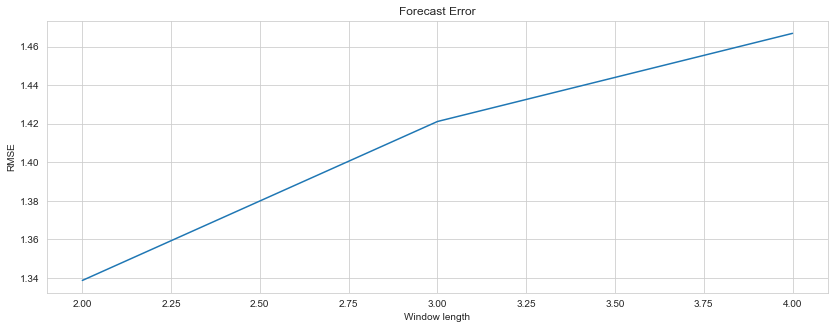

In [57]:
best_rmse_rf_2, best_window_len_rf_2, rmse_df_rf_2 = identify_opt_sliding_window(rf_mod_2, 
                                                         X_train, X_test_reduced,
                                                         Y_train, Y_test_reduced,
                                                         feats_to_use,
                                                         min_window_len=2,
                                                         max_window_len=5,
                                                         step_size = 1)

**OBSERVATIONS**

* The **RMSE has slightly reduced** *(about 0.001)* for the regressor with different `n_estimator` value.
* Still, the observed **RMSE is higher than the naive forecast's RMSE** value.


**FINAL CONCLUSIONS**

* Even thought the **Random Forest** algorithm produces **better results** than **Linear Regression** model(s), still the forecast error is <u>significantly higher than of the naive-forecast/daily-presistence forecast</u>.


* **Therefore, I believe it's safe to assume that using `RandomForest` algorithm to forecast `Close` price(s) would not be suitable.**

#### 4.4.5 Forecasting using  XGBoost

Seeing that the **previously fitted models does not perform as per our expectations**, in this section I am focusing on using `XGBoost` ; one of the most famous/widely used algorithms especially dominating in many Kaggle competitions as the winner solution as well as used by many data science professionals in industry.

* Similar to `RandomForest`, `XGBoost` algorithm also falls under the family of **ensemble learning** algorithms which makes the **final prediction by aggregating results** of many different models.

* As we know, **Random Forest** uses **bagging** *(boostrap aggregating)* as it's ensemble method where a series of decision trees get **parellaly trained by performing boostrap sampling** on the train data.


`XGBoost` stands for e**X**treme **G**radient **Boost**ing. As the name suggests, it uses **boosting** ensemble method where a series of decision trees are built **sequentially** in a way that, **each individual tree tries to rectify the errors made by the previous tree**. 
* The **gradient boosting** process XGBoost employs develop these sequence of decisions trees in a way that, **each tree tries to learn from residuals of the tree** *(difference between predicted and true values of a tree)* built before. *(instead of focusing on wrongly predicted train-samples as in other boosting algorithms)*.

* Similar to any other ensemble learning algorithm, XGBoost also makes the new prediction by simply adding up the predictions of all trees.

##### 4.4.5.1 Fitting a XGBoost Regressor with default hyperparameters

* Since both <u>Random Forest and XGBoost are ensemble algorithms</u>, instead of trying out the full scope of sliding-window lengths that we tested for previous regressors *(i.e., from 2-days to 260-days)*, here I make the assumption that even for XGBoost regressor, the **optimal sliding window-length would be <u>2-days</u>**.

* Even so, in order to confirm this assumption, below I run the `identify_opt_sliding_window` function for **2 to 5 days lengths** and check for the minimum RMSE.

In [58]:
xgb_mod_1 = XGB.XGBRegressor( objective= 'reg:squarederror',n_jobs=-1, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:41<00:00, 40.58s/it]


- Minimum RMSE of 1.3230506243640252 is resulted at the sliding window length of 2 day(s)


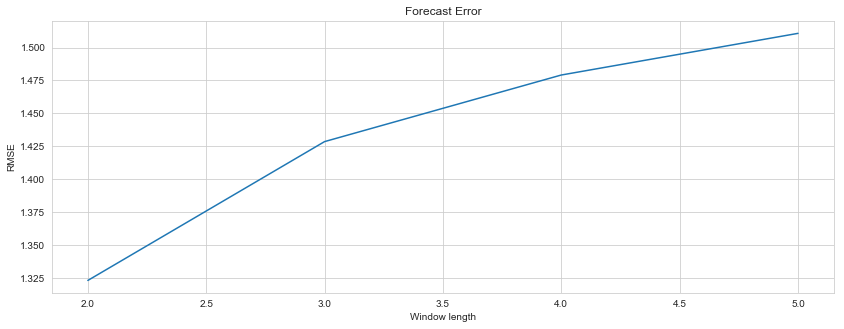

In [59]:
best_rmse_xgb_1, best_window_len_xgb_1, rmse_df_xgb_1 = identify_opt_sliding_window(xgb_mod_1, 
                                                                         X_train, X_test_reduced,
                                                                         Y_train, Y_test_reduced,
                                                                         feats_to_use,
                                                                         min_window_len=2,
                                                                         max_window_len=6,
                                                                         step_size = 1)

**OBSERVATIONS**:

* The initial assumption we made, i.e., the **optimal window length for the XGB regressor to be similar of the Random Forest regressor** is proved *(2-days)*
* Even with the default hyperparameter values, **XGBoost regressor performs *(slightly)* better than the manually tuned Random-Forest regressor** *(RMSE of 1.3231)*
* Still, the recorded RMSE score is **higher than of the naive-forecast model**.


Now, in order to see if manually tuning the hyperparameter values would result with an improved RMSE score, I try few different values for several hyperparameters in the following section

##### 4.4.5.2 Manually tune XGBoost Regressor's hyperparameters

Given that `XGBoost` model has so **many tuneable hyperparameters** *(even more than of Random Forest)*, here I will only consider the below mentioned **3** hyperparameters; which I believe to have a higher importance in generating better predictions:
* `n_estimators` : maximum number of trees to fit
* `max_depth` : maximum possible depth for a single tree
* `min_child_weight` : minimum number of samples needed in order to create a new node in a tree
* `learning_rate` : learning rate *(defines the amount of "correction" we make at each step)*
    

##### 4.4.5.2.1 Optimizing hyperparameters with bayesian optimization

The reason to perform hyperparameter tuning is to find the hyperparameter values that will result with best performance.

* Ideally, if the **hyperparameter space is small**, we can perform **Grid-Search** and try all possible combinations and decide the best values to use.
* But as the hyperparameter space grows, it is not feasible to do so thus we have to find alternative ways to pick the best performing hyperparameter values.


In such scenarios, **bayesian optimization** can be used since it keeps **track of the past evaluation results of different combinations of hyperparameter values tested before** and make **"informed decisions"** in choosing which hyperparameter values to test in the search *(thus results with less number of iterations)*

* For Bayesian Optimization process, we can define the **estimator function we want to optimize**. 

* Once that is done, we can **pass ranges for a defined set of hyperparameters** and let bayesian optimization find the hyperparameter values which **maximizes the output of the defined function**.


For our use-case, below I start by defining a function which returns the **negative RMSE** value for a fitted XGB Regressor and try to **maximize this score over different value combinations** for our interested hyperparameters *(which we described above)*

In [60]:
# create a data-matrix for XGBoost model
dtrain = XGB.DMatrix(generate_features(X_train,'Close')[feats_to_use], label=Y_train)

In [61]:
# define estimator function
def xgb_evaluation(n_estimators, max_depth, min_child_weight, learning_rate):
    
    params = {'objective' : 'reg:squarederror',
              'eval_metric': 'rmse',
              'n_jobs': -1,
              'min_child_weight' : min_child_weight,
              'learning_rate': learning_rate,
              'max_depth': int(max_depth),
              'n_estimators' : n_estimators}
        
    cv_result = XGB.cv(params, dtrain, nfold=3)    
    
    # Bayesian optimization only maximizes, so we should return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [62]:
# define hyperparameter-space
hyperparameter_space = {'learning_rate': (0,1) ,
                        'max_depth': (1, 20),
                        'n_estimators' : (1,1500),
                        'min_child_weight' : (1,50)}

In [63]:
# perform bayesian-optimization
xgb_bo = BayesianOptimization(xgb_evaluation, hyperparameter_space,  verbose = 10)

xgb_bo.maximize(init_points=3, n_iter=300, acq='ei')

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
|  1        | -12.71    |  0.1268   |  12.51    |  2.412    |  23.05    |
|  2        | -1.472    |  0.6803   |  3.095    |  26.16    |  336.4    |
|  3        | -1.36     |  0.7035   |  15.71    |  47.19    |  1.227e+0 |
|  4        | -48.22    |  0.000807 |  3.137    |  25.47    |  336.4    |
|  5        | -1.502    |  0.8299   |  4.261    |  40.48    |  886.9    |
|  6        | -1.369    |  0.896    |  18.77    |  19.33    |  720.9    |
|  7        | -1.837    |  0.3039   |  19.92    |  16.7     |  627.8    |
|  8        | -1.32     |  0.7157   |  7.972    |  5.239    |  729.7    |
|  9        | -1.286    |  0.4192   |  7.629    |  32.8     |  631.1    |
|  10       | -1.818    |  0.7988   |  2.541    |  5.247    |  1.032e+0 |
|  11       | -1.366    |  0.8125   |  12.96    |  36.67    |  1.287e+0 |
|  12       | -34.73    |  0.03332  | 

|  219      | -37.39    |  0.02611  |  16.76    |  10.4     |  1.085e+0 |
|  220      | -1.398    |  0.5404   |  4.322    |  34.43    |  901.1    |
|  221      | -8.455    |  0.1631   |  16.58    |  47.74    |  882.6    |
|  222      | -1.237    |  0.5811   |  19.22    |  23.36    |  753.0    |
|  223      | -26.5     |  0.05937  |  8.701    |  22.76    |  651.6    |
|  224      | -2.864    |  0.4714   |  1.207    |  7.042    |  416.4    |
|  225      | -1.362    |  0.8947   |  11.46    |  29.51    |  113.3    |
|  226      | -1.169    |  0.5039   |  12.47    |  10.41    |  807.9    |
|  227      | -1.203    |  0.4692   |  14.76    |  25.35    |  1.051e+0 |
|  228      | -1.714    |  0.7467   |  2.995    |  19.57    |  385.0    |
|  229      | -1.404    |  0.9006   |  9.699    |  24.3     |  1.279e+0 |
|  230      | -18.3     |  0.09396  |  15.83    |  37.95    |  1.078e+0 |
|  231      | -1.872    |  0.308    |  9.111    |  43.09    |  293.0    |
|  232      | -1.464    |  0.3518   | 

In [64]:
print(f'Best resulting hyperparameter values:\n\n {xgb_bo.max}')

Best resulting hyperparameter values:

 {'target': -1.1411516666666668, 'params': {'learning_rate': 0.49942609310394115, 'max_depth': 17.502903895302385, 'min_child_weight': 1.1825460410625648, 'n_estimators': 317.0090408144853}}


In [65]:
xgb_opt = XGB.XGBRegressor(learning_rate = 0.5,
                       max_depth = 17,
                       n_estimators = 317,
                       min_child_weight = 1,
                       objective= 'reg:squarederror',
                       n_jobs=-1, 
                       verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:30<00:00, 70.14s/it]


- Minimum RMSE of 1.3271553440947406 is resulted at the sliding window length of 2 day(s)


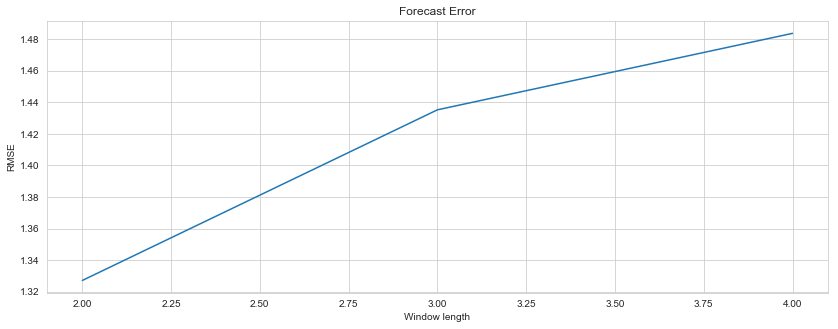

In [66]:
best_rmse_xgb_2, best_window_len_xgb_2, rmse_df_xgb_2 = identify_opt_sliding_window(xgb_opt, 
                                                         X_train, X_test_reduced,
                                                         Y_train, Y_test_reduced,
                                                         feats_to_use,
                                                         min_window_len=2,
                                                         max_window_len=5,
                                                         step_size = 1)

**OBSERVATIONS**:

Unfortunately, the tuned model seem to perform **worse** than of the default XGBoost regressor *(RMSE increase by 0.004)*.

* I believe this has happened due to the fact that, the bayesian optimization process we employed **did not take into account the <u>sliding-window</u> during the optimization phase**, thus should have **over-fitted the training samples** used for optimization and performce **worse during the testing** phase.


**Ultimately, I derive the conclusion that, even though <u>XGBoost regressor showcase *(slightly)* improved performance than of the Random Forest Regressor</u>, it still <u>fails to perform better than the naive-forecast</u> model.**

#### 4.4.6 Forecasting using Vector Autoregression *(VAR)*

Witnessing that all <u>previous models failed</u> in making a better forecast against the naive-model, as the last resort, in this section I try implementing a different model which is **specifically designed to tackle time-series forecasting problems.**


* It's evident that our dataset is made out of <u>several time-series features and the target time-series</u>, traditional time-series forecasting models such as **ARIMA** or **SARIMA** would not work for our problem.

* Considering this <u>multivariate-time series nature</u> of our problem, in this section I implement one of the most commonly used methods for multivariate time series forecasting, which is the **Vector Auto Regression *(VAR)*** model.

* In **VAR models**, each variable is treated as a **linear function of its past values** as well as of the past values of all the other variables input to the model.

A simple **VAR(1)** model for a **bivariate system** can be written as : 


$$\begin{pmatrix}
{y}_{1t}\\
{y}_{2t}
\end{pmatrix}= 
\begin{bmatrix}
{a}_{11}&{a}_{12}\\
{a}_{21}&{a}_{22}
\end{bmatrix}
\begin{pmatrix}
{y}_{1t-1}\\
{y}_{2t-1}
\end{pmatrix} + 
\begin{pmatrix}
{\varepsilon}_{1t}\\
{\varepsilon}_{2t}
\end{pmatrix}  $$

Prior we move on to fit the VAR model, it's crucial that we confirm the **input data aligns with model assumptions**, thus I structure the modelling approach within this section as below:
1. Check for causation of data
1. Check stationarity and make non-stationary time series stationary
1. Deciding the order (lag) for the VAR model
1. Train VAR model with the pre-defined lag/order
1. Forecast using the fitted VAR model and walk-forward process

##### 4.4.6.1 Check for causation of data

* As mentioned before, VAR models are built upon the assumption that **each time series in the system influences each other**. 

* In order to confirm that assumption holds for our dataset, I use **[Granger’s Causality Test](https://www.statisticshowto.datasciencecentral.com/granger-causality/)** which checks whether one time series is useful in forecasting another.


* The null hypothesis of the test is that **lagged feature-data do not explain the variation in a response variable**, thus obtaining a p-value less than a specific significance threshold will allow us to reject that hypothesis. 

The below code perform Granger’s Causality test for all possible combinations of the time series data our training dataset and shows p-values of each variable combination.

In [86]:
def grangers_causation_check(data, variables, maxlag):    
    """Function to check Granger Causality of all possible combinations of the variables.
    
    Output : rows are the response variable and columns are features. 
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in df.columns:
        for row in df.index:
            warnings.filterwarnings('ignore')
            test_result = grangercausalitytests(data[[row, col]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[row, col] = min_p_value
    df.columns = [var + '_as_feat' for var in variables]
    df.index = [var + '_as_resp' for var in variables]
    return df

In [87]:
train_df_X_Y = pd.concat([generate_features(X_train,'Close')[feats_to_use],Y_train],axis=1)
train_df_X_Y.dropna(inplace=True)

In [89]:
# Assumption: 2 month's historical data of each variable would be sufficient for causality test 
maxlag=(20*2)

grangers_causation_check(train_df_X_Y, train_df_X_Y.columns, maxlag)     

,Close_sma_7_as_feat,Close_FFT_20_comp_as_feat,Close_MACD_as_feat,Close_BB_upper_as_feat,Close_ema_20_as_feat,Close_FFT_10_comp_as_feat,Close_FFT_5_comp_as_feat,Close_sma_21_as_feat,Close_ema_50_as_feat,traded_vol_mean_imp_as_feat,Close_BB_lower_as_feat,Close_as_feat
Close_sma_7_as_resp,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Close_FFT_20_comp_as_resp,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Close_MACD_as_resp,0.0000,0.0000,1.0000,0.0000,0.0000,0.0047,0.0224,0.0000,0.0000,0.0583,0.0000,0.0556
Close_BB_upper_as_resp,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Close_ema_20_as_resp,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2417,0.0000
Close_FFT_10_comp_as_resp,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Close_FFT_5_comp_as_resp,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Close_sma_21_as_resp,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Close_ema_50_as_resp,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
traded_vol_mean_imp_as_resp,0.0000,0.0016,0.0000,0.0021,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


**OUTPUT INTERPRETATION**:

The values that we observe in the above table are the p-values. 
* In the matrix, p-values lesser than the significance level (0.05) implies that the null hypothesis can be rejected, i.e., **respective feature *(column)* variable causes the response *(row)* variable**.


* After observing the results, we can see that **almost every time-series variable considered are interchangeably causing each other**. 


* But given that our main focus is to forecast `Close` time series, it's observable that `Close_MACD`, `Close_ema_20`, `Close_sma_21`, `Close_ema_50` and `Close_BB_lower` variables do not happen to cause `Close`.


* Therefore, considerign these non-significant p-values, I will **drop the above listed variables from the feature space  during the modeling**.


##### 4.4.6.2 Check stationarity and make non-stationary time series stationary

* VAR models, like most other traditional time-series forecast models require the **time-series data to be stationary** *(i.e.,  statistical properties such as mean, variance, autocorrelation, etc. does not change over time)*


* Therefore in this section;
    * First I perform **Augmented Dickey-Fuller Test** to check each time series for stationarity and,
    * For non-stationary time-series, **perform differencing** until they become stationary.
    
    

In [270]:
def perform_adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller test to check for Stationarity """
    
    result = adfuller(series, autolag='AIC')
    
    output = {'test_statistic':round(result[0], 4), 
              'pvalue':round(result[1], 4), 
              'n_lags':round(result[2], 4), 
              'n_obs':result[3]}
    
    p_value = output['pvalue'] 
    
    # generate summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*40)
    print(f' Null Hypothesis: Data is Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    if p_value <= signif:
        print(f" - P-Value = {p_value}. Rejecting Null Hypothesis.\n  - Series is Stationary.")
    else:
        print(f" - p-Value = {p_value}. Not enough evidence to reject the Null Hypothesis.\n - Series is Non-Stationary.")

* Perform Augmented Dickey-Fuller Test on each time series

In [271]:
for name, col in train_df_X_Y.iteritems():
    perform_adfuller_test(col, name=col.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close_sma_7" 
    ----------------------------------------
 Null Hypothesis: Data is Non-Stationary.
 Significance Level    = 0.05
 No. Lags Chosen       = 26
 - p-Value = 0.8148. Not enough evidence to reject the Null Hypothesis.
 - Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Close_FFT_20_comp" 
    ----------------------------------------
 Null Hypothesis: Data is Non-Stationary.
 Significance Level    = 0.05
 No. Lags Chosen       = 6
 - p-Value = 0.8936. Not enough evidence to reject the Null Hypothesis.
 - Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Close_MACD" 
    ----------------------------------------
 Null Hypothesis: Data is Non-Stationary.
 Significance Level    = 0.05
 No. Lags Chosen       = 6
 - P-Value = 0.0. Rejecting Null Hypothesis.
  - Series is Stationary.


    Augmented Dickey-Fuller Test on "Close_BB_upper" 
    ----------------------------------------
 Null Hypothesis: Data is Non-S

* By observing the above results, we can see that most of the time-series data is non-stationary.
* Therefore, to obtain stationarity for those variables, we will need to perform differencing.

It's also noteworthy that, for **VAR models**, all variables should contain the **same number of observations**, therefore, when differencing, we will have to difference **all variables**, not only the non-stationary ones. *(if only non-stationary variables are differenced, they will have a lesser number of observations than the rest)*

* Perform initial differencing step

In [90]:
# initial difference
train_df_X_Y_diff_1 = train_df_X_Y.diff().dropna()

* Re-run Augmented Dickey-Fuller Test

In [272]:
for name, col in train_df_X_Y_diff_1.iteritems():
    perform_adfuller_test(col, name=col.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close_sma_7" 
    ----------------------------------------
 Null Hypothesis: Data is Non-Stationary.
 Significance Level    = 0.05
 No. Lags Chosen       = 25
 - P-Value = 0.0. Rejecting Null Hypothesis.
  - Series is Stationary.


    Augmented Dickey-Fuller Test on "Close_FFT_20_comp" 
    ----------------------------------------
 Null Hypothesis: Data is Non-Stationary.
 Significance Level    = 0.05
 No. Lags Chosen       = 6
 - p-Value = 0.9059. Not enough evidence to reject the Null Hypothesis.
 - Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Close_MACD" 
    ----------------------------------------
 Null Hypothesis: Data is Non-Stationary.
 Significance Level    = 0.05
 No. Lags Chosen       = 17
 - P-Value = 0.0. Rejecting Null Hypothesis.
  - Series is Stationary.


    Augmented Dickey-Fuller Test on "Close_BB_upper" 
    ----------------------------------------
 Null Hypothesis: Data is Non-Stationary.
 Significance Leve

After the initial differencing step, we can see that still the `Close_FFT_20_comp` and `Close_FFT_5_comp` variables appears to be non-stationary at 5% significance level.

* Therefore, I will **avoid using these 2 variables** in any VAR model that I will develop in the later stages.

##### 4.4.6.3 Deciding the order (lag) for the VAR model

Recall that the structure of VAR models is that **each variable is a linear function of past lags of itself and past lags of the other variables**.

Therefore, when implementing the model for a specific collection of time series data, we need to define the **correct order (or lag) for the particular VAR model** which represents the **number of lags it should regress on** for each time series variable.

* And to achieve that, below I use the `model.select_order(maxlags)` method which outputs different information criteria *(‘AIC’ *([Akaike information](https://en.wikipedia.org/wiki/Akaike_information_criterion))*, ‘BIC’ *([Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion))*, ‘FPE’ *([Akaike’s Final Prediction Error](https://www.mathworks.com/help/ident/ref/fpe.html))* and ‘HQIC’ *([Hannan–Quinn information criterion](https://en.wikipedia.org/wiki/Hannan%E2%80%93Quinn_information_criterion))* )* scores at each lag/order(p) so that we can **select the lag corresponding to the lowest of these measurements**.

Before stepping into the model selection process, first let's prepare the **list of variables to use for the VAR model** *(after dropping the variables that had high p-values under Granger’s Causality Test  *(i.e., the variables which do not cause the `Close` price)* as well as the non-stationary time series variables identified through the  Augmented Dickey-Fuller Test)*

In [106]:
VAR_vars_to_use = ['Close_sma_7', 
                    'Close_BB_upper',
                    'Close_FFT_10_comp', 
                    'traded_vol_mean_imp',
                    'Close']

In [107]:
VAR_mod = VAR(endog=train_df_X_Y_diff_1[VAR_vars_to_use])

* Below, I check until a maximum of **20 lags**, which corresponds to approximately 1 month's data *(assuming 20 days per month)*

In [110]:
VAR_mod_selection = VAR_mod.select_order(maxlags=20)
VAR_mod_selection.summary()

,AIC,BIC,FPE,HQIC
0,21.02,21.03,1.345e+09,21.02
1,9.263,9.332,1.054e+04,9.288
2,0.3582,0.4848,1.431,0.4041
3,-8.471,-8.287,0.0002095,-8.404
4,-16.40,-16.15,7.579e-08,-16.31
5,-16.40,-16.10,7.580e-08,-16.29
6,-38.53*,-38.17*,1.851e-17*,-38.40*
7,-35.88,-35.46,2.618e-16,-35.73
8,-30.31,-29.84,6.830e-14,-30.14
9,-29.72,-29.19,1.237e-13,-29.53


* And by observing the above results, it's evident that the best lag is defined at **lag 6** which records the **minimum scores across all evaluation criteria**.

##### 4.4.6.4 Train VAR model with the pre-defined lag/order

In [116]:
VAR_mod_fit = VAR_mod.fit(6)
VAR_mod_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 31, Aug, 2019
Time:                     10:44:34
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -37.6889
Nobs:                     2550.00    HQIC:                  -37.9153
Log likelihood:           30569.8    FPE:                3.00360e-17
AIC:                     -38.0441    Det(Omega_mle):     2.82750e-17
--------------------------------------------------------------------
Results for equation Close_sma_7
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.002651         0.002591            1.024           0.306
L1.Close_sma_7                 0.018668         0.028839            0.647           0.517
L1.Close_BB_upper 

Now we have our model fitted on the training data. Thus the next step would be to make the forecast and evaluate forecast accuracy as we did for the previous models.

##### 4.4.6.5 Forecast using the fitted VAR model and walk-forward process

As you can imagine, for the fitted VAR model to make a forecast, it requires **input observations up to the lag order number** from historical training data.

Therefore, the **walk forward process** we implement should have a sliding window length of **6-days** and with that, predict the values for the immediate day after the training duration.


* Prior moving to implement the complete walk-forward process, below I make a forecast for the first sample/time-step in the test dataset

In [117]:
# get the fitted model's lag-order
lag_order = VAR_mod_fit.k_ar

In [118]:
# prepare input data to make forecast
VAR_train_input = train_df_X_Y_diff_1[VAR_vars_to_use].values[-lag_order:]

In [119]:
# make the single-step forecast
single_step_forecast = VAR_mod_fit.forecast(y=VAR_train_input, steps=1)

# prepare the 1-day-differenced forecasted dataframe
single_step_forecast = pd.DataFrame(single_step_forecast, columns= [col + '_1day_diff' for col in VAR_vars_to_use])
single_step_forecast['Date'] = pd.to_datetime(train_set.index[0],format="%Y%m%D"),
single_step_forecast.set_index('Date',inplace=True)
single_step_forecast.T

Date,2005-05-02
Close_sma_7_1day_diff,-0.179853
Close_BB_upper_1day_diff,-0.436565
Close_FFT_10_comp_1day_diff,-0.262086
traded_vol_mean_imp_1day_diff,-19104.542906
Close_1day_diff,-0.098965


* As we can observe, even though the model has generated a forecast, the **scale of the forecast** is of the input training data, meaning they are **differenced**.


* Therefore, in order to transform the forecast to the original scale, we need to **de-difference** this forecast.

In [120]:
def de_difference(train_data, forecast_data):
    """Remove differencing and transform the forecast to original scale."""

    df_fc = forecast_data.copy()
    de_diff_fc = pd.DataFrame()
    
    columns = train_data.columns
    
    for col in columns:        
        
        de_diff_fc[str(col)+'_forecast'] = train_data[col].iloc[-1] + df_fc[str(col)+'_1day_diff'].cumsum()
    
    return de_diff_fc

In [121]:
de_difference(train_df_X_Y[VAR_vars_to_use],single_step_forecast).T

Date,2005-05-02
Close_sma_7_forecast,8.721872e+01
Close_BB_upper_forecast,8.971176e+01
Close_FFT_10_comp_forecast,5.972368e+01
traded_vol_mean_imp_forecast,5.224564e+06
Close_forecast,8.623103e+01


* We can observe that the **forecast** is not only made for the `Close` price, but for **each variable that we input in to the VAR model**.


* Since our aim is only to **make a prediction on the `Close` price**, let's evaluate the forecasted close price againt the true value and measure any deviance.

In [153]:
date_ = pd.to_datetime(test_set.index[0], format = "%Y%m%D")
forecasted = de_difference(train_df_X_Y[VAR_vars_to_use],single_step_forecast)['Close_forecast']
true_value = test_set['Close'][0]
abs_diff = np.abs(forecasted - true_value)
print(f'\nForecast made for Close price on {date_.date()} : \n -True Value : {true_value} \n -Forecasted Value : {np.round(forecasted[0],2)}\n -Abs. difference : {np.round(abs_diff[0],2)}')


Forecast made for Close price on 2015-05-04 : 
 -True Value : 87.55 
 -Forecasted Value : 86.23
 -Abs. difference : 1.32


* We can observe that the forecasted value is still off from the actual.


In order to get an overal view of the predictive power of the VAR model, below I implement the complete walk-forwad process, incoporating each of the steps that we performed above.

In [123]:
def walk_forward_validation_VAR_model(x_train, x_test, y_train, y_test, feats_to_use, VAR_vars_to_use, lag):
    
    temp_x_train = x_train
    temp_x_test = x_test
    
    temp_y_train = y_train
    temp_y_test = y_test
    
    predictions = []
    step_wise_RMSE = []
        
    for obs in tqdm(range(x_test.shape[0])):
        
        warnings.filterwarnings("ignore")           
        
        # feature-engineer x_train data
        x_train_ft_engineerd = generate_features(temp_x_train,'Close')[feats_to_use]

        # construct a single dataframe containing both X and Y training data
        temp_train_full = pd.concat([x_train_ft_engineerd,temp_y_train],axis=1)

        # select the list of columns to feed into VAR model        
        temp_train_full = temp_train_full[VAR_vars_to_use]
        
        # perform 1st order differencing and drop missing data
        temp_train_full_diff = temp_train_full.diff().dropna()
                
        # if lag defined - adjust the training data length
        if lag is not None:
            temp_train_full_diff_adj = temp_train_full_diff.iloc[-lag:,:]
            
            
        # fit the model
        VAR_mod = VAR(endog=temp_train_full_diff)
        VAR_mod_fit = VAR_mod.fit(lag)
        
        # get the fitted model's lag-order
        lag_order = VAR_mod_fit.k_ar
        
        # make the single-step forecast
        single_step_forecast = VAR_mod_fit.forecast(y=temp_train_full_diff_adj.values, steps=1)

        # prepare the 1-day-differenced forecasted dataframe
        single_step_forecast = pd.DataFrame(single_step_forecast, columns= [col + '_1day_diff' for col in VAR_vars_to_use])
        single_step_forecast['Date'] = pd.to_datetime(temp_x_test.index[obs],format="%Y%m%D"),
        single_step_forecast.set_index('Date',inplace=True)

        # de-difference toe forecast
        date_ = pd.to_datetime(temp_x_test.index[obs], format = "%Y%m%D")
        forecast_val = de_difference(temp_train_full[VAR_vars_to_use],single_step_forecast)['Close_forecast']
                
        # append forecast to list
        predictions.append(forecast_val[0])
        #print(predictions)
                
        # update training feature set by including the last forecasted date's feature data from test set 
        temp_x_train = temp_x_train.append(pd.DataFrame(temp_x_test.iloc[obs]).T)    
        
        # label the x_train index (required for feature-engineering process during next-iteration)
        temp_x_train.index.name = 'Date'

        # extract the last forecasted date's true target value from the test set
        latest_val = pd.DataFrame({'Close': pd.Series(temp_y_test)[obs]}, index = [pd.Series(temp_y_test).index[obs]])
        
        # update the training target set by including the last forecasted date's true target value
        temp_y_train = temp_y_train.append(latest_val['Close']) 

        # label the y_train index (required for feature-engineering process during next-iteration)
        temp_y_train.index.name = 'Date'
        
        # calculate the RMSE for the predictions
        step_wise_RMSE.append(evaluate_forecast(temp_y_test[:obs+1],predictions[:obs+1]))
            
    
    # prepare df of predictions
    predictions = pd.DataFrame(predictions,x_test.index)

    # RMSE for the complete forecast
    RMSE_score = evaluate_forecast(y_test, predictions)

    # generate actual-vs-forecast and error plots
    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
    
    ax[0].plot(y_test,c ='r', alpha = 0.8, label = 'True-value')
    ax[0].plot(predictions,  'b--', alpha = 0.9, label = 'Forecast-value')
    ax[0].legend(fontsize=10)
    ax[0].set_ylabel('Close price')
    ax[0].set_xlabel('Day')
    ax[0].set_title('Forecast vs Actual for Test data\n', fontsize=12)
    
    ax[1].plot(step_wise_RMSE)
    ax[1].set_title(f'Forecast Error',  fontsize=12)
    ax[1].set_xlabel('Test Samples')
    ax[1].set_ylabel('RMSE')
    
    plt.tight_layout()
    plt.show()
    
    print(f'- RMSE for forecast is : {RMSE_score}')
    
    return RMSE_score, predictions, step_wise_RMSE

* Now let's run the above implemented process and check it's performance:

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:36<00:00, 14.36it/s]


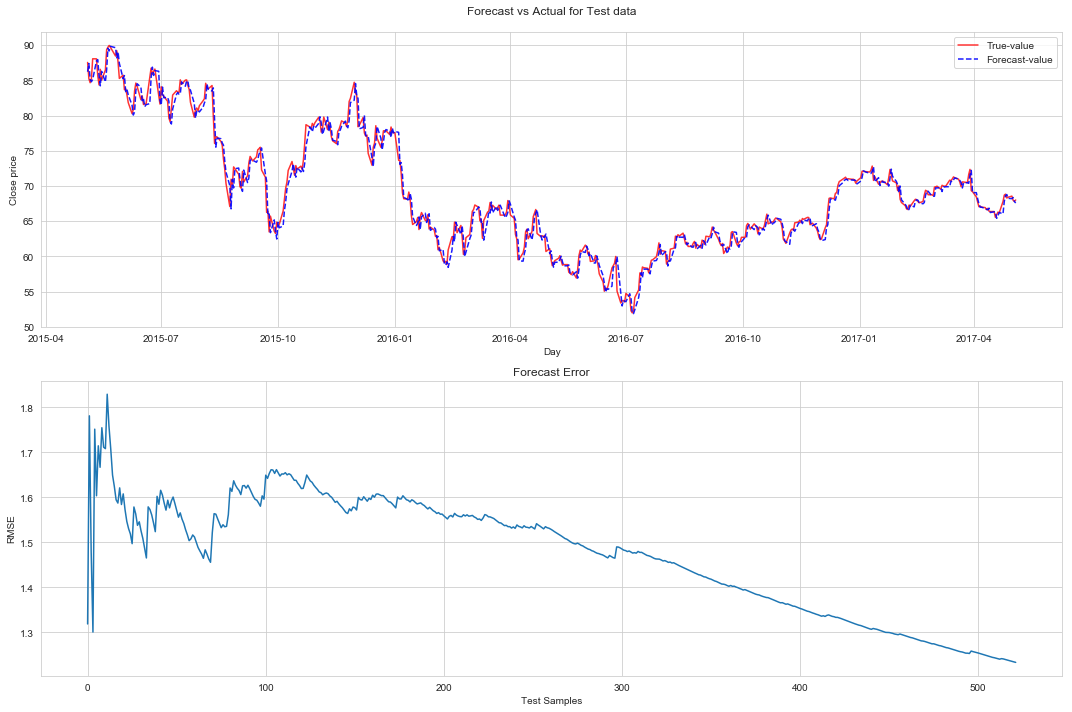

- RMSE for forecast is : 1.233617264451666


In [129]:
best_rmse_VAR, forecast_VAR, stepwise_rmse_VAR = walk_forward_validation_VAR_model(X_train, X_test_reduced, 
                                                                  Y_train, Y_test_reduced, 
                                                                  feats_to_use, 
                                                                  VAR_vars_to_use,
                                                                  lag=6)

**OBSERVATIONS**:

* The fitted VAR model *(with a lag of 6 days)* results with the **least RMSE we've achieved across all models tested so far.**
* Further, the **execution time** of the walk-forward process for VAR model is **extremely low** compared against all other algorithms fitted as of now.
* Still, the resulting **RMSE is slightly higher than the naive-forecast** *(about 0.01 points higher)*

**CONCLUSIONS**:

* Overall, VAR model seems to be the **best candicate model to tackle the problem**.


* Knowing that VAR models are specifically designed to tackle time-series modelling problems, the capability that VAR models have in **identifying the autocorrelations in time series data** should be one of the reasons why it **performs better** than the previously fitted models.


* This also proves the fact that, our **data contains a considerable amount of auto-correlation**.



**Even though the VAR model performs better than the rest, not being able to <u>out-perform the naive model forecast</u> provides us evidence that this model's <u>forecasting capabilities are WEAK!</u>**

---
## 5. DISCUSSION

Considering that the main focus of this project was to successfully forecast closing price of a stock *(Daimler Group's)* for a future day using a machine learning/statistical algorithm, after witnessing the results generated during the data modeling stage, it is possible to arrive at the conclusion that none of the developed models demonstrate noteworthy forecasting capabilities/results.

All developed models were able to make a single-step forecast with an average RMSE between 1 to 2 price units *(euros)* for the close price, but even though this error appears to be small, when considering the tight-price-ranges that the stock prices fluctuate we can understand that any trading decision made while having such an RMSE score will most likely be a risky decision.

Even more, we saw that the none of the models performed better than the naive-presistence forecast, thus it further provides evidence for us to not put any trust on the forecasting capabilities of these models.

Therefore, I assume it's fair to arrive at the conclusion that, in order develop a machine learning model that is capable of generating accurate forecasts of stock prices will not be a simple process and likely require thorough research to be performed before identifying any probable models/algorithms/techniques that can exceed at least exceed the naive-forecast performance.

### 5.1 Learnings and future research suggestions

This section I would like to dedicate to mention some of my learnings and point of few other approaches which can be tested in order to check whether incorporating those processes would yeild to developing ML models with improved forecasting capabilities:

#### 5.1.1. Learnings:

* Splitting data to Train-Test sets and performing model validation on time-series data is different from the generic approaches as both these processes should take in to account the 'time' aspect of data.
* For stock price forecasting methodologies, utilizing a "sliding-window" approach tend to generate better results than the expanding window.
* Traded stock-volumes and simple moving averages of the historical price data tend to create accurate price signals.
* Limiting the feature-space strictly to stock-price data is not recommended.
* Even though tree-based algorithms are considered as few of the most generalizable ML algorithms in use that performs well in tackling many prediction problems, they tend to fall short when working with time-series forecasting tasks.
* It's always best to implement ML algorithms which can take into account the 'auto-correlations' and temporal dependencies when tryint to solve a time-series problem.
* In practice, if the generated forecast is used to make trade decisions at low time-frames *(15-mins/1-hr/4-hr intervals)*, the model training time is going to play a major role, thus light-weight models which are easy/quick to train would be preferred.

#### 5.1.2. Further research opportunities: